In [1]:
import string
import math
import nltk
import itertools
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, plot_roc_curve
from sklearn import metrics
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from string import digits
from textblob import TextBlob
from geotext import GeoText
from spellchecker import SpellChecker
from numpy import array, argmax

# Data Visualisation

In [2]:
# Downloading nltk packages
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('words', quiet=True)

# Setting options
pd.options.display.max_rows = 50
pd.set_option('mode.chained_assignment', None)
np.set_printoptions(precision=4, suppress=True)

In [3]:
# Loading dataset and dividing it into training and testing

data = pd.read_csv('train.csv')
data.set_index('id', inplace=True)

X_train, X_test, Y_train, Y_test = train_test_split(data, data['target'], stratify = data['target'], test_size = 0.3)
X_train.sort_index(ascending = True, inplace = True) 
Y_train.sort_index(ascending = True, inplace = True) 
X_test.sort_index(ascending = True, inplace = True) 
Y_test.sort_index(ascending = True, inplace = True) 

print("The train set has ", "%.2f" % (Y_train.value_counts()[0]/Y_train.value_counts().sum()*100), '% non-disaster tweets')
print("The train set has ", "%.2f" % (Y_test.value_counts()[1]/Y_test.value_counts().sum()*100), '% disaster tweets')

# X_train

The train set has  57.03 % non-disaster tweets
The train set has  42.95 % disaster tweets


# Data Cleaning - training set

In [4]:
# For VADER sentiment analysis the raw unprocessed text is needed
X_train['raw_text'] = X_train['text']

## Data Cleaning: the 'text' field

In [5]:
# How many tweets we have with the same text
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
  print(len(X_train[X_train['raw_text'].duplicated()]))

64


In [6]:
# Data Cleaning on the text column:

# There should be no empty tweets
assert X_train['text'].isnull().sum() == 0

# Remove duplicates (~100 tweets)
X_train.drop_duplicates(subset ='text', keep = 'first', inplace = True) 

# Gets rid of unknown characters
X_train['text'] = X_train['text'].apply(lambda x: x.encode('ascii', errors = 'ignore').decode('utf-8'))

# Transform everything to lower case
X_train['text'] = X_train['text'].str.lower()

# Extract hashtags and add them to new column:
X_train['hashtags'] = ''
extract = re.compile('(#\S+)')
hashtags = X_train['text'].str.extractall(extract)

X_train.reset_index(inplace = True) # Add the hashtags in a new column
hashtags.reset_index(inplace = True)

hashtags = hashtags.groupby('id')[0].apply(lambda x: "{%s}" % ', '.join(x)) # group all hashtags by id
hashtags = hashtags.to_frame()
hashtags.reset_index(inplace = True)

for index, row in hashtags.iterrows(): # Add all hashtags in the data set wherever it is the case
  X_train.at[X_train['id'] == row['id'], 'hashtags'] = row[0]

X_train.set_index('id', inplace=True)

# Remove hashtags from text
for index, ht in enumerate(X_train.text):
  X_train['text'].iloc[index] = re.sub(extract, '', ht)

# Remove numbers from text
X_train.text = X_train.text.apply(lambda x: np.nan if type(x) != str else ''.join([i for i in x if not i.isdigit()]))

# Extract tagged people and add them in new column:
X_train['tags'] = ''
extract_tag = re.compile('(@\S+)')
tags = X_train['text'].str.extractall(extract_tag)

X_train.reset_index(inplace = True) # Add the hashtags in a new column
tags.reset_index(inplace = True)

tags = tags.groupby('id')[0].apply(lambda x: "{%s}" % ', '.join(x)) # group all hashtags by id
tags = tags.to_frame()
tags.reset_index(inplace = True)

for index, row in tags.iterrows(): # Add all hashtags in the data set wherever it is the case
  X_train.at[X_train['id'] == row['id'], 'tags'] = row[0]

X_train.set_index('id', inplace=True)

# Remove tagged people from text
for index, ht in enumerate(X_train.text):
  X_train['text'].iloc[index] = re.sub(extract_tag, '', ht)

# Extract links and add their number in a new column
X_train['links'] = 0
extract_links = re.compile('(https?:\/\/)(\w+\.)*([\w\-\s]+\/)*([\w-]+)\/?')
links = X_train['text'].str.extractall(extract_links)

links.reset_index(inplace = True) # Add the count into a new column
links = links.groupby(['id'])['match'].sum()
links += 1

links = links.to_frame()
links.reset_index(inplace = True)
X_train.reset_index(inplace = True)

for index, row in links.iterrows(): # Add the number of links in the data set wherever it is the case
  X_train.at[X_train['id'] == row['id'], 'links'] = row[1]

X_train.set_index('id', inplace=True)

# Remove links from text
for index, tweet in enumerate(X_train.text):
  X_train['text'].iloc[index] = re.sub(extract_links, '', tweet)

# Remove Punctutation
X_train['text'] = [str(entry).translate(str.maketrans('','',string.punctuation)) for entry in X_train['text']]

# Remove Stopwords
stop_words = set(stopwords.words('english')) 
X_train['text'] = X_train['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

# Tokenize
for index, sentence in enumerate(X_train.text):
    X_train['text'].iloc[index] = word_tokenize(sentence)

# Remove plural forms
for index, entry in enumerate(X_train['text']):
  new_sentence = []
  for word in entry:
    singular = TextBlob(word).words[0].singularize()
    new_sentence.append(singular)
  X_train.text.iloc[index] = new_sentence

In [7]:
# Lemmatization - especially good with verbs

lemmatizer = WordNetLemmatizer()

for index, entry in enumerate(X_train['text']):
  new_sentence = []
  for word in entry:
    lem = lemmatizer.lemmatize(word, pos='v')
    new_sentence.append(lem)
  X_train.text.iloc[index] = new_sentence

## Data Cleaning: the 'location' field

In [8]:
# Replace %20 with spaces
X_train.keyword = X_train.keyword.apply(lambda x: np.nan if type(x) != str else x.replace('%20', ' '))

In [9]:
# Get rid of unknown characters:
X_train.location = X_train.location.apply(lambda x: np.nan if type(x) != str else x.encode('ascii', errors = 'ignore').decode('utf-8'))

# Get rid of numbers:
X_train.location = X_train.location.apply(lambda x: np.nan if type(x) != str else ''.join([i for i in x if not i.isdigit()]))

extract = re.compile('(#)') # Get rid of hashtags
for index, ht in enumerate(X_train.location):
  if type(X_train.location.iloc[index]) == str:
    X_train.location.iloc[index] = re.sub(extract, '', ht)

# Remove punctuation
X_train.location = X_train.location.apply(lambda x: np.nan if type(x) != str else x.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation))))
X_train[X_train.location.notnull()]

,keyword,location,text,target,raw_text,hashtags,tags,links
id,,,,,,,,
48,ablaze,Birmingham,"[wholesale, market, ablaze]",1,@bbcmtd Wholesale Markets ablaze http://t.co/l...,,{@bbcmtd},1
50,ablaze,AFRICA,"[break, newsnigerium, flag, set, ablaze, aba]",1,#AFRICANBAZE: Breaking news:Nigeria flag set a...,{#africanbaze:},,1
52,ablaze,Philadelphia PA,"[cry, set, ablaze]",0,Crying out for more! Set me ablaze,,,0
53,ablaze,London UK,"[plu, side, look, sky, last, night, ablaze]",0,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,,,1
54,ablaze,Pretoria,"[theyve, build, much, hype, around, new, acqui...",0,@PhDSquares #mufc they've built so much hype a...,{#mufc},{@phdsquares},0
...,...,...,...,...,...,...,...,...
10824,wrecked,Denton Texas,"[awesome, time, gettin, wreck, bowl, last, night]",0,Had an awesome time gettin wrecked at bowling ...,,,1
10826,wrecked,TN,"[bright, side, wreck]",0,On the bright side I wrecked http://t.co/uEa0t...,,,1
10829,wrecked,NewcastleuponTyne UK,"[hes, go, relax, think, wife, wreck, cake, gon...",0,@widda16 ... He's gone. You can relax. I thoug...,{#whoops},{@widda},0


In [10]:
# Transforming locations 

# First step: states
# From abreviation to state name
# Extract the states to new feature
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

X_train['states'] = ''
final_states =  {k.lower(): v for k, v in states.items()}
final_states2 =  {k: v.lower() for k, v in states.items()}

for index, location in enumerate(X_train['location']):
  if type(X_train['location'].iloc[index]) != str:
    continue
    
  for word in location.split():
    if word.lower() in final_states.keys():
      X_train['location'].iloc[index] = final_states[word.lower()]
      X_train['states'].iloc[index] = final_states[word.lower()]
    elif word.lower() in final_states2.values():
      X_train['states'].iloc[index] = word.lower().title()

In [11]:
# Second step: countries
# From abreviation to country name
countries = {
	'AD': 'Andorra',
	'AE': 'United Arab Emirates',
	'AF': 'Afghanistan',
	'AG': 'Antigua & Barbuda',
	'AI': 'Anguilla',
	'AL': 'Albania',
	'AM': 'Armenia',
	'AN': 'Netherlands Antilles',
	'AO': 'Angola',
	'AQ': 'Antarctica',
	'AR': 'Argentina',
	'AS': 'American Samoa',
	'AT': 'Austria',
	'AU': 'Australia',
	'AW': 'Aruba',
	'AZ': 'Azerbaijan',
	'BA': 'Bosnia and Herzegovina',
	'BB': 'Barbados',
	'BD': 'Bangladesh',
	'BE': 'Belgium',
	'BF': 'Burkina Faso',
	'BG': 'Bulgaria',
	'BH': 'Bahrain',
	'BI': 'Burundi',
	'BJ': 'Benin',
	'BM': 'Bermuda',
	'BN': 'Brunei Darussalam',
	'BO': 'Bolivia',
	'BR': 'Brazil',
	'BS': 'Bahama',
	'BT': 'Bhutan',
	'BU': 'Burma (no longer exists)',
	'BV': 'Bouvet Island',
	'BW': 'Botswana',
	'BY': 'Belarus',
	'BZ': 'Belize',
	'CA': 'Canada',
	'CC': 'Cocos (Keeling) Islands',
	'CF': 'Central African Republic',
	'CG': 'Congo',
	'CH': 'Switzerland',
	'CI': 'Côte D\'ivoire (Ivory Coast)',
	'CK': 'Cook Iislands',
	'CL': 'Chile',
	'CM': 'Cameroon',
	'CN': 'China',
	'CO': 'Colombia',
	'CR': 'Costa Rica',
	'CS': 'Czechoslovakia (no longer exists)',
	'CU': 'Cuba',
	'CV': 'Cape Verde',
	'CX': 'Christmas Island',
	'CY': 'Cyprus',
	'CZ': 'Czech Republic',
	'DD': 'German Democratic Republic (no longer exists)',
	'DE': 'Germany',
	'DJ': 'Djibouti',
	'DK': 'Denmark',
	'DM': 'Dominica',
	'DO': 'Dominican Republic',
	'DZ': 'Algeria',
	'EC': 'Ecuador',
	'EE': 'Estonia',
	'EG': 'Egypt',
	'EH': 'Western Sahara',
	'ER': 'Eritrea',
	'ES': 'Spain',
	'ET': 'Ethiopia',
	'FI': 'Finland',
	'FJ': 'Fiji',
	'FK': 'Falkland Islands (Malvinas)',
	'FM': 'Micronesia',
	'FO': 'Faroe Islands',
	'FR': 'France',
	'FX': 'France, Metropolitan',
	'GA': 'Gabon',
	'GB': 'Great Britain',
	'GD': 'Grenada',
	'GE': 'Georgia',
	'GF': 'French Guiana',
	'GH': 'Ghana',
	'GI': 'Gibraltar',
	'GL': 'Greenland',
	'GM': 'Gambia',
	'GN': 'Guinea',
	'GP': 'Guadeloupe',
	'GQ': 'Equatorial Guinea',
	'GR': 'Greece',
	'GS': 'South Georgia and the South Sandwich Islands',
	'GT': 'Guatemala',
	'GU': 'Guam',
	'GW': 'Guinea-Bissau',
	'GY': 'Guyana',
	'HK': 'Hong Kong',
	'HM': 'Heard & McDonald Islands',
	'HN': 'Honduras',
	'HR': 'Croatia',
	'HT': 'Haiti',
	'HU': 'Hungary',
	'ID': 'Indonesia',
	'IE': 'Ireland',
	'IL': 'Israel',
	'IN': 'India',
	'IO': 'British Indian Ocean Territory',
	'IQ': 'Iraq',
	'IR': 'Islamic Republic of Iran',
	'IS': 'Iceland',
	'IT': 'Italy',
	'JM': 'Jamaica',
	'JO': 'Jordan',
	'JP': 'Japan',
	'KE': 'Kenya',
	'KG': 'Kyrgyzstan',
	'KH': 'Cambodia',
	'KI': 'Kiribati',
	'KM': 'Comoros',
	'KN': 'St. Kitts and Nevis',
	'KP': 'Korea, Democratic People\'s Republic of',
	'KR': 'Korea, Republic of',
	'KW': 'Kuwait',
	'KY': 'Cayman Islands',
	'KZ': 'Kazakhstan',
	'LA': 'Lao People\'s Democratic Republic',
	'LB': 'Lebanon',
	'LC': 'Saint Lucia',
	'LI': 'Liechtenstein',
	'LK': 'Sri Lanka',
	'LR': 'Liberia',
	'LS': 'Lesotho',
	'LT': 'Lithuania',
	'LU': 'Luxembourg',
	'LV': 'Latvia',
	'LY': 'Libyan Arab Jamahiriya',
	'MA': 'Morocco',
	'MC': 'Monaco',
	'MD': 'Moldova, Republic of',
	'MG': 'Madagascar',
	'MH': 'Marshall Islands',
	'ML': 'Mali',
	'MN': 'Mongolia',
	'MM': 'Myanmar',
	'MO': 'Macau',
	'MP': 'Northern Mariana Islands',
	'MQ': 'Martinique',
	'MR': 'Mauritania',
	'MS': 'Monserrat',
	'MT': 'Malta',
	'MU': 'Mauritius',
	'MV': 'Maldives',
	'MW': 'Malawi',
	'MX': 'Mexico',
	'MY': 'Malaysia',
	'MZ': 'Mozambique',
	'NA': 'Namibia',
	'NC': 'New Caledonia',
	'NE': 'Niger',
	'NF': 'Norfolk Island',
	'NG': 'Nigeria',
	'NI': 'Nicaragua',
	'NL': 'Netherlands',
	'NO': 'Norway',
	'NP': 'Nepal',
	'NR': 'Nauru',
	'NT': 'Neutral Zone (no longer exists)',
	'NU': 'Niue',
	'NZ': 'New Zealand',
	'OM': 'Oman',
	'PA': 'Panama',
	'PE': 'Peru',
	'PF': 'French Polynesia',
	'PG': 'Papua New Guinea',
	'PH': 'Philippines',
	'PK': 'Pakistan',
	'PL': 'Poland',
	'PM': 'St. Pierre & Miquelon',
	'PN': 'Pitcairn',
	'PR': 'Puerto Rico',
	'PT': 'Portugal',
	'PW': 'Palau',
	'PY': 'Paraguay',
	'QA': 'Qatar',
	'RE': 'Réunion',
	'RO': 'Romania',
	'RU': 'Russian Federation',
	'RW': 'Rwanda',
	'SA': 'Saudi Arabia',
	'SB': 'Solomon Islands',
	'SC': 'Seychelles',
	'SD': 'Sudan',
	'SE': 'Sweden',
	'SG': 'Singapore',
	'SH': 'St. Helena',
	'SI': 'Slovenia',
	'SJ': 'Svalbard & Jan Mayen Islands',
	'SK': 'Slovakia',
	'SL': 'Sierra Leone',
	'SM': 'San Marino',
	'SN': 'Senegal',
	'SO': 'Somalia',
	'SR': 'Suriname',
	'ST': 'Sao Tome & Principe',
	'SU': 'Union of Soviet Socialist Republics (no longer exists)',
	'SV': 'El Salvador',
	'SY': 'Syrian Arab Republic',
	'SZ': 'Swaziland',
	'TC': 'Turks & Caicos Islands',
	'TD': 'Chad',
	'TF': 'French Southern Territories',
	'TG': 'Togo',
	'TH': 'Thailand',
	'TJ': 'Tajikistan',
	'TK': 'Tokelau',
	'TM': 'Turkmenistan',
	'TN': 'Tunisia',
	'TO': 'Tonga',
	'TP': 'East Timor',
	'TR': 'Turkey',
	'TT': 'Trinidad & Tobago',
	'TV': 'Tuvalu',
	'TW': 'Taiwan, Province of China',
	'TZ': 'Tanzania, United Republic of',
	'UA': 'Ukraine',
	'UG': 'Uganda',
  'UK': 'United Kingdom',
	'UM': 'United States Minor Outlying Islands',
	'US': 'United States',
  'USA': 'United States',
	'UY': 'Uruguay',
	'UZ': 'Uzbekistan',
	'VA': 'Vatican City State (Holy See)',
	'VC': 'St. Vincent & the Grenadines',
	'VE': 'Venezuela',
	'VG': 'British Virgin Islands',
	'VI': 'United States Virgin Islands',
	'VN': 'Viet Nam',
	'VU': 'Vanuatu',
	'WF': 'Wallis & Futuna Islands',
	'WS': 'Samoa',
	'YD': 'Democratic Yemen (no longer exists)',
	'YE': 'Yemen',
	'YT': 'Mayotte',
	'YU': 'Yugoslavia',
	'ZA': 'South Africa',
	'ZM': 'Zambia',
	'ZR': 'Zaire',
	'ZW': 'Zimbabwe',
	'ZZ': 'Unknown or unspecified country',
}

for index, location in enumerate(X_train['location']):
  if type(X_train['location'].iloc[index]) != str:
    continue
    
  for word in location.split():
    if word in countries.keys():
      X_train['location'].iloc[index] = countries[word]

## Data Cleaning: the 'hashtags' field

In [12]:
# Remove Punctutation
X_train['hashtags'] = [str(entry).translate(str.maketrans('','',string.punctuation)) for entry in X_train['hashtags']]

# Get rid of numbers
X_train.hashtags = X_train.hashtags.apply(lambda x: np.nan if type(x) != str else ''.join([i for i in x if not i.isdigit()]))

# Data Cleaning - test set

In [13]:
# ON THE TEXT FIELD:

# For VADER sentiment analysis the raw unprocessed text is needed
X_test['raw_text'] = X_test['text']

# Data Cleaning on the text column:

# There should be no empty tweets
assert X_test['text'].isnull().sum() == 0

# Remove duplicates (~100 tweets)
X_test.drop_duplicates(subset ='text', keep = 'first', inplace = True) 

# Gets rid of unknown characters
X_test['text'] = X_test['text'].apply(lambda x: x.encode('ascii', errors = 'ignore').decode('utf-8'))

# Transform everything to lower case
X_test['text'] = X_test['text'].str.lower()

# Extract hashtags and add them to new column:
X_test['hashtags'] = ''
extract = re.compile('(#\S+)')
hashtags = X_test['text'].str.extractall(extract)

X_test.reset_index(inplace = True) # Add the hashtags in a new column
hashtags.reset_index(inplace = True)

hashtags = hashtags.groupby('id')[0].apply(lambda x: "{%s}" % ', '.join(x)) # group all hashtags by id
hashtags = hashtags.to_frame()
hashtags.reset_index(inplace = True)

for index, row in hashtags.iterrows(): # Add all hashtags in the data set wherever it is the case
  X_test.at[X_test['id'] == row['id'], 'hashtags'] = row[0]

X_test.set_index('id', inplace=True)

# Remove hashtags from text
for index, ht in enumerate(X_test.text):
  X_test['text'].iloc[index] = re.sub(extract, '', ht)

# Remove numbers from text
X_test.text = X_test.text.apply(lambda x: np.nan if type(x) != str else ''.join([i for i in x if not i.isdigit()]))

# Extract tagged people and add them in new column:
X_test['tags'] = ''
extract_tag = re.compile('(@\S+)')
tags = X_test['text'].str.extractall(extract_tag)

X_test.reset_index(inplace = True) # Add the hashtags in a new column
tags.reset_index(inplace = True)

tags = tags.groupby('id')[0].apply(lambda x: "{%s}" % ', '.join(x)) # group all hashtags by id
tags = tags.to_frame()
tags.reset_index(inplace = True)

for index, row in tags.iterrows(): # Add all hashtags in the data set wherever it is the case
  X_test.at[X_test['id'] == row['id'], 'tags'] = row[0]

X_test.set_index('id', inplace=True)

# Remove tagged people from text
for index, ht in enumerate(X_test.text):
  X_test['text'].iloc[index] = re.sub(extract_tag, '', ht)

# Extract links and add their number in a new column
X_test['links'] = 0
extract_links = re.compile('(https?:\/\/)(\w+\.)*([\w\-\s]+\/)*([\w-]+)\/?')
links = X_test['text'].str.extractall(extract_links)

links.reset_index(inplace = True) # Add the count into a new column
links = links.groupby(['id'])['match'].sum()
links += 1

links = links.to_frame()
links.reset_index(inplace = True)
X_test.reset_index(inplace = True)

for index, row in links.iterrows(): # Add the number of links in the data set wherever it is the case
  X_test.at[X_test['id'] == row['id'], 'links'] = row[1]

X_test.set_index('id', inplace=True)

# Remove links from text
for index, tweet in enumerate(X_test.text):
  X_test['text'].iloc[index] = re.sub(extract_links, '', tweet)

# Remove Punctutation
X_test['text'] = [str(entry).translate(str.maketrans('','',string.punctuation)) for entry in X_test['text']]

# Remove Stopwords
stop_words = set(stopwords.words('english')) 
X_test['text'] = X_test['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

# Tokenize
for index, sentence in enumerate(X_test.text):
    X_test['text'].iloc[index] = word_tokenize(sentence)

# Remove plural forms
for index, entry in enumerate(X_test['text']):
  new_sentence = []
  for word in entry:
    singular = TextBlob(word).words[0].singularize()
    new_sentence.append(singular)
  X_test.text.iloc[index] = new_sentence

# Lemmatization - especially good with verbs

lemmatizer = WordNetLemmatizer()

for index, entry in enumerate(X_test['text']):
  new_sentence = []
  for word in entry:
    lem = lemmatizer.lemmatize(word, pos='v')
    new_sentence.append(lem)
  X_test.text.iloc[index] = new_sentence

# ON THE LOCATION FIELD:
# Replace %20 with spaces
X_test.keyword = X_test.keyword.apply(lambda x: np.nan if type(x) != str else x.replace('%20', ' '))

# Get rid of unknown characters:
X_test.location = X_test.location.apply(lambda x: np.nan if type(x) != str else x.encode('ascii', errors = 'ignore').decode('utf-8'))

# Get rid of numbers:
X_test.location = X_test.location.apply(lambda x: np.nan if type(x) != str else ''.join([i for i in x if not i.isdigit()]))

extract = re.compile('(#)') # Get rid of hashtags
for index, ht in enumerate(X_test.location):
  if type(X_test.location.iloc[index]) == str:
    X_test.location.iloc[index] = re.sub(extract, '', ht)

# Remove punctuation
X_test.location = X_test.location.apply(lambda x: np.nan if type(x) != str else x.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation))))

# Transforming locations 

# First step: states
# From abreviation to state name
# Extract the states to new feature
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

X_test['states'] = ''
final_states =  {k.lower(): v for k, v in states.items()}
final_states2 =  {k: v.lower() for k, v in states.items()}

for index, location in enumerate(X_test['location']):
  if type(X_test['location'].iloc[index]) != str:
    continue
    
  for word in location.split():
    if word.lower() in final_states.keys():
      X_test['location'].iloc[index] = final_states[word.lower()]
      X_test['states'].iloc[index] = final_states[word.lower()]
    elif word.lower() in final_states2.values():
      X_test['states'].iloc[index] = word.lower().title()

# Second step: countries
# From abreviation to country name
countries = {
	'AD': 'Andorra',
	'AE': 'United Arab Emirates',
	'AF': 'Afghanistan',
	'AG': 'Antigua & Barbuda',
	'AI': 'Anguilla',
	'AL': 'Albania',
	'AM': 'Armenia',
	'AN': 'Netherlands Antilles',
	'AO': 'Angola',
	'AQ': 'Antarctica',
	'AR': 'Argentina',
	'AS': 'American Samoa',
	'AT': 'Austria',
	'AU': 'Australia',
	'AW': 'Aruba',
	'AZ': 'Azerbaijan',
	'BA': 'Bosnia and Herzegovina',
	'BB': 'Barbados',
	'BD': 'Bangladesh',
	'BE': 'Belgium',
	'BF': 'Burkina Faso',
	'BG': 'Bulgaria',
	'BH': 'Bahrain',
	'BI': 'Burundi',
	'BJ': 'Benin',
	'BM': 'Bermuda',
	'BN': 'Brunei Darussalam',
	'BO': 'Bolivia',
	'BR': 'Brazil',
	'BS': 'Bahama',
	'BT': 'Bhutan',
	'BU': 'Burma (no longer exists)',
	'BV': 'Bouvet Island',
	'BW': 'Botswana',
	'BY': 'Belarus',
	'BZ': 'Belize',
	'CA': 'Canada',
	'CC': 'Cocos (Keeling) Islands',
	'CF': 'Central African Republic',
	'CG': 'Congo',
	'CH': 'Switzerland',
	'CI': 'Côte D\'ivoire (Ivory Coast)',
	'CK': 'Cook Iislands',
	'CL': 'Chile',
	'CM': 'Cameroon',
	'CN': 'China',
	'CO': 'Colombia',
	'CR': 'Costa Rica',
	'CS': 'Czechoslovakia (no longer exists)',
	'CU': 'Cuba',
	'CV': 'Cape Verde',
	'CX': 'Christmas Island',
	'CY': 'Cyprus',
	'CZ': 'Czech Republic',
	'DD': 'German Democratic Republic (no longer exists)',
	'DE': 'Germany',
	'DJ': 'Djibouti',
	'DK': 'Denmark',
	'DM': 'Dominica',
	'DO': 'Dominican Republic',
	'DZ': 'Algeria',
	'EC': 'Ecuador',
	'EE': 'Estonia',
	'EG': 'Egypt',
	'EH': 'Western Sahara',
	'ER': 'Eritrea',
	'ES': 'Spain',
	'ET': 'Ethiopia',
	'FI': 'Finland',
	'FJ': 'Fiji',
	'FK': 'Falkland Islands (Malvinas)',
	'FM': 'Micronesia',
	'FO': 'Faroe Islands',
	'FR': 'France',
	'FX': 'France, Metropolitan',
	'GA': 'Gabon',
	'GB': 'Great Britain',
	'GD': 'Grenada',
	'GE': 'Georgia',
	'GF': 'French Guiana',
	'GH': 'Ghana',
	'GI': 'Gibraltar',
	'GL': 'Greenland',
	'GM': 'Gambia',
	'GN': 'Guinea',
	'GP': 'Guadeloupe',
	'GQ': 'Equatorial Guinea',
	'GR': 'Greece',
	'GS': 'South Georgia and the South Sandwich Islands',
	'GT': 'Guatemala',
	'GU': 'Guam',
	'GW': 'Guinea-Bissau',
	'GY': 'Guyana',
	'HK': 'Hong Kong',
	'HM': 'Heard & McDonald Islands',
	'HN': 'Honduras',
	'HR': 'Croatia',
	'HT': 'Haiti',
	'HU': 'Hungary',
	'ID': 'Indonesia',
	'IE': 'Ireland',
	'IL': 'Israel',
	'IN': 'India',
	'IO': 'British Indian Ocean Territory',
	'IQ': 'Iraq',
	'IR': 'Islamic Republic of Iran',
	'IS': 'Iceland',
	'IT': 'Italy',
	'JM': 'Jamaica',
	'JO': 'Jordan',
	'JP': 'Japan',
	'KE': 'Kenya',
	'KG': 'Kyrgyzstan',
	'KH': 'Cambodia',
	'KI': 'Kiribati',
	'KM': 'Comoros',
	'KN': 'St. Kitts and Nevis',
	'KP': 'Korea, Democratic People\'s Republic of',
	'KR': 'Korea, Republic of',
	'KW': 'Kuwait',
	'KY': 'Cayman Islands',
	'KZ': 'Kazakhstan',
	'LA': 'Lao People\'s Democratic Republic',
	'LB': 'Lebanon',
	'LC': 'Saint Lucia',
	'LI': 'Liechtenstein',
	'LK': 'Sri Lanka',
	'LR': 'Liberia',
	'LS': 'Lesotho',
	'LT': 'Lithuania',
	'LU': 'Luxembourg',
	'LV': 'Latvia',
	'LY': 'Libyan Arab Jamahiriya',
	'MA': 'Morocco',
	'MC': 'Monaco',
	'MD': 'Moldova, Republic of',
	'MG': 'Madagascar',
	'MH': 'Marshall Islands',
	'ML': 'Mali',
	'MN': 'Mongolia',
	'MM': 'Myanmar',
	'MO': 'Macau',
	'MP': 'Northern Mariana Islands',
	'MQ': 'Martinique',
	'MR': 'Mauritania',
	'MS': 'Monserrat',
	'MT': 'Malta',
	'MU': 'Mauritius',
	'MV': 'Maldives',
	'MW': 'Malawi',
	'MX': 'Mexico',
	'MY': 'Malaysia',
	'MZ': 'Mozambique',
	'NA': 'Namibia',
	'NC': 'New Caledonia',
	'NE': 'Niger',
	'NF': 'Norfolk Island',
	'NG': 'Nigeria',
	'NI': 'Nicaragua',
	'NL': 'Netherlands',
	'NO': 'Norway',
	'NP': 'Nepal',
	'NR': 'Nauru',
	'NT': 'Neutral Zone (no longer exists)',
	'NU': 'Niue',
	'NZ': 'New Zealand',
	'OM': 'Oman',
	'PA': 'Panama',
	'PE': 'Peru',
	'PF': 'French Polynesia',
	'PG': 'Papua New Guinea',
	'PH': 'Philippines',
	'PK': 'Pakistan',
	'PL': 'Poland',
	'PM': 'St. Pierre & Miquelon',
	'PN': 'Pitcairn',
	'PR': 'Puerto Rico',
	'PT': 'Portugal',
	'PW': 'Palau',
	'PY': 'Paraguay',
	'QA': 'Qatar',
	'RE': 'Réunion',
	'RO': 'Romania',
	'RU': 'Russian Federation',
	'RW': 'Rwanda',
	'SA': 'Saudi Arabia',
	'SB': 'Solomon Islands',
	'SC': 'Seychelles',
	'SD': 'Sudan',
	'SE': 'Sweden',
	'SG': 'Singapore',
	'SH': 'St. Helena',
	'SI': 'Slovenia',
	'SJ': 'Svalbard & Jan Mayen Islands',
	'SK': 'Slovakia',
	'SL': 'Sierra Leone',
	'SM': 'San Marino',
	'SN': 'Senegal',
	'SO': 'Somalia',
	'SR': 'Suriname',
	'ST': 'Sao Tome & Principe',
	'SU': 'Union of Soviet Socialist Republics (no longer exists)',
	'SV': 'El Salvador',
	'SY': 'Syrian Arab Republic',
	'SZ': 'Swaziland',
	'TC': 'Turks & Caicos Islands',
	'TD': 'Chad',
	'TF': 'French Southern Territories',
	'TG': 'Togo',
	'TH': 'Thailand',
	'TJ': 'Tajikistan',
	'TK': 'Tokelau',
	'TM': 'Turkmenistan',
	'TN': 'Tunisia',
	'TO': 'Tonga',
	'TP': 'East Timor',
	'TR': 'Turkey',
	'TT': 'Trinidad & Tobago',
	'TV': 'Tuvalu',
	'TW': 'Taiwan, Province of China',
	'TZ': 'Tanzania, United Republic of',
	'UA': 'Ukraine',
	'UG': 'Uganda',
  'UK': 'United Kingdom',
	'UM': 'United States Minor Outlying Islands',
	'US': 'United States',
  'USA': 'United States',
	'UY': 'Uruguay',
	'UZ': 'Uzbekistan',
	'VA': 'Vatican City State (Holy See)',
	'VC': 'St. Vincent & the Grenadines',
	'VE': 'Venezuela',
	'VG': 'British Virgin Islands',
	'VI': 'United States Virgin Islands',
	'VN': 'Viet Nam',
	'VU': 'Vanuatu',
	'WF': 'Wallis & Futuna Islands',
	'WS': 'Samoa',
	'YD': 'Democratic Yemen (no longer exists)',
	'YE': 'Yemen',
	'YT': 'Mayotte',
	'YU': 'Yugoslavia',
	'ZA': 'South Africa',
	'ZM': 'Zambia',
	'ZR': 'Zaire',
	'ZW': 'Zimbabwe',
	'ZZ': 'Unknown or unspecified country',
}

for index, location in enumerate(X_test['location']):
  if type(X_test['location'].iloc[index]) != str:
    continue
    
  for word in location.split():
    if word in countries.keys():
      X_test['location'].iloc[index] = countries[word]

# ON THE HASHTAGS FIELD:
# Remove Punctutation
X_test['hashtags'] = [str(entry).translate(str.maketrans('','',string.punctuation)) for entry in X_test['hashtags']]

# Get rid of numbers
X_test.hashtags = X_test.hashtags.apply(lambda x: np.nan if type(x) != str else ''.join([i for i in x if not i.isdigit()]))

# Data Exploration - training set

**Feature List:**

I. Location:
- [x] state
- [x] city
- [x] country

II. Keyword:
- [x] number of keywords per tweet
- [x] How likely it is that a keyword is actually associated with a real disaster
- [x] Count Keywords which are in Tweet Hashtags (solved problem -- standardize to same length vector)

III. Text:
- [x] Word count
- [x] Number of characters
- [x] Mean word length
- [x] VADER Sentiment Analysis: pos, neg, neu, compound:
- [x] Frequency Count matrix / tf-idf matrix


IV. Miscellaneous:
- [x] Number of Embedded Links per Tweet
- [x] Bool value of Hashtag present in a Tweet









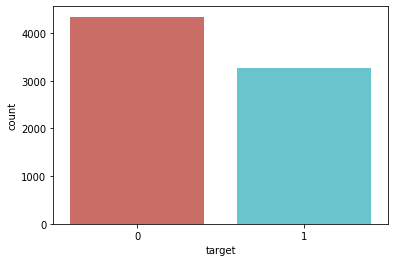

In [14]:
#Exploring
#graph that counts the targets 
sns.countplot(x='target', data=data, palette='hls')
plt.show()

## Location:

In [15]:
# Create city and country features
X_train['city'] = X_train.apply(lambda x: GeoText(x['location']).cities[0] if type(x['location']) != float and len(GeoText(x['location']).cities) > 0 else np.nan, axis=1)
X_train['country'] = X_train.apply(lambda x: GeoText(x['location']).countries[0] if type(x['location']) != float and len(GeoText(x['location']).countries) > 0 else np.nan, axis=1)

## Keywords:

In [16]:
# No of keywords/tweet as a new feature

X_train['keyword'].fillna('nan', inplace=True)
X_train['disaster_words_in_text'] = 0

keywords = X_train['keyword'].unique()
no_of_keywords = []

for index, row in X_train.iterrows():
  count = 0
  for word in keywords:
    if word in row['raw_text']:
      count = count+1
  no_of_keywords.append(count)

X_train['disaster_words_in_text'] = no_of_keywords

In [17]:
# How likely it is that a keyword is actually associated with a real disaster
X_train['keyword_disaster_ratio'] = float('nan')

for index, row in X_train.iterrows():
  if row.keyword != 'nan':
    ratio = X_train.loc[np.logical_and(X_train.target == 1, X_train.keyword == row.keyword)].shape[0] / (X_train.loc[np.logical_and(X_train.target == 1, X_train.keyword == row.keyword)].shape[0] + X_train.loc[np.logical_and(X_train.target == 0, X_train.keyword == row.keyword)].shape[0])
    X_train['keyword_disaster_ratio'][index] = ratio

# Change features to make them suitable for this model:
X_train['keyword_disaster_ratio'].fillna(0.5, inplace = True)

In [18]:
# Feature: Count Keywords of Tweets in hashtags
keywords = list(X_train['keyword'].value_counts().index)
keywords.pop(0)
for i in range(len(keywords)):
    keywords[i] = keywords[i].replace(' ', '')

list_hashtag = []
for i in range(len(X_train['hashtags'])):
  hashtags = X_train['hashtags'].iloc[i]
  hashtags = hashtags.split(',')
  list_hashtags = []
  count = 0
  for l in range(len(hashtags)):
    hashtags[l] = hashtags[l].replace('#', '')
    hashtags[l] = hashtags[l].replace('}', '')
    hashtags[l] = hashtags[l].replace('{', '')
    hashtags[l] = hashtags[l].replace(',', '')
    list_hashtags.append(hashtags[l])
    for k in range(len(list_hashtags)):
      for j in range(len(keywords)):
        if keywords[j] == list_hashtags[k]:
          count = count + 1
  list_hashtag.append(count)

X_train['count_#keywords'] = list_hashtag

## Hashtag:

In [19]:
# Find the hashtags that are used 100% in a disaster tweet
# Could be a usefull feature

vectorizer_hashtags = CountVectorizer(min_df = 5)
hashtags_vec = vectorizer_hashtags.fit_transform(X_train['hashtags'])
X_train_hashtags = pd.DataFrame(hashtags_vec.toarray(), columns=vectorizer_hashtags.get_feature_names())

new_dataframe = X_train['target'].reset_index()
new_dataframe.drop(columns = ['id'], inplace = True)
X_train_hashtags.sum(axis=0)

top_hashtags = (X_train_hashtags.transpose().dot(new_dataframe.T.squeeze()) / X_train_hashtags.sum(axis = 0)).sort_values(ascending=False)
top_disaster_htags = list(top_hashtags[top_hashtags == 1].index)

X_train['Top Disaster Hashtags'] = 0

for index, htag in enumerate(X_train['hashtags']):
  count = 0
  for top_htag in top_disaster_htags:
    if htag is not None and htag == top_htag:
      count+= 1
      X_train['Top Disaster Hashtags'].iloc[index] = count


In [20]:
# Hashtag count

X_train['hashtags_number'] = 0
for index, row in X_train.iterrows():
  X_train['hashtags_number'][index] = len(row.hashtags.split())

X_train['tags_number'] = 0
for index, row in X_train.iterrows():
  X_train['tags_number'][index] = len(row.tags.split())

In [21]:
# Feature: Bool Hashtags -- Does having a hashtag affect the disaster status?
list_bool = []
for i in range(len(X_train['hashtags'])):
  if bool(X_train['hashtags'].iloc[i]):
    list_bool.append(1)
  else:
    list_bool.append(0)
X_train['hashtags_bool'] = list_bool
X_train['target'].corr(X_train['hashtags_bool'])

0.06402995902344623

## Text:

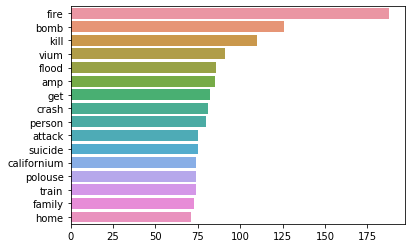

In [22]:
# Most used words when target == 1
list_of_words = []
for sentence in X_train.loc[X_train.target == 1, 'text']:
  for word in sentence:
    list_of_words.append(word)
word_frequency = FreqDist(list_of_words)
used_words = list(word_frequency.most_common())[:16]
sns.barplot([x[1] for x in used_words], [x[0] for x in used_words])

In [23]:
# Finding most used words when target == 1 and add the number of words that appear in every tweet to a new column
count_most_used_words = []
for index,sentence in enumerate(X_train.text):
  for word in [x[0] for x in used_words]:
    if word in sentence:
      count_most_used_words.append((index, sentence.count(word)))

X_train['Important words frequency'] = 0
for index, value in enumerate(X_train['Important words frequency']):
  for word_index, value2 in count_most_used_words:
    if word_index == index:
      X_train['Important words frequency'].iloc[index] = value2

In [24]:
# Word count of text / How many words there are in each text
X_train['number_of_words'] = 0

count = X_train['raw_text'].str.split().apply(len)
X_train['number_of_words'] = count

# No. of characters per tweet
X_train['number_of_characters'] = 0
for index, row in X_train.iterrows():
  X_train['number_of_characters'][index] = len(row.raw_text)

# Mean word length / The mean length of words in each text
X_train['mean_word_length'] = 0.00
for index, row in X_train.iterrows():
  X_train['mean_word_length'][index] = len(row.raw_text) / row.number_of_words


In [25]:
# Count punctuation symbols per tweet:

X_train['punctuation_symbols'] = 0
for index, row in X_train.iterrows():
  for character in row.raw_text:
    if character in string.punctuation:
      X_train['punctuation_symbols'][index] += 1

# Count stop words per tweet:
X_train['stopwords_count'] = 0
for index, row in X_train.iterrows():
  for word in stop_words:
    if word in row.raw_text.split():
      X_train['stopwords_count'][index] +=1

In [26]:
# How much of the tweet is gramatically

spell = SpellChecker()

for index, row in X_train.iterrows():
  X_train['tags_number'][index] = len(row.tags.split())

grammar_nazi = []
for index, row in X_train.iterrows():
  tweet = row.raw_text.split()
  length_of_tweet = len(tweet)
  spelling_errors = len(spell.unknown(tweet))
  correctness_ratio = (length_of_tweet - spelling_errors) / length_of_tweet
  grammar_nazi.append(correctness_ratio)

X_train['text_correctness_ratio'] = grammar_nazi

In [27]:
# SENTIMENT ANALYSIS WITH VADER

list_score = []
analyzer = SentimentIntensityAnalyzer()
for i in range(len(X_train['raw_text'])):
    score = analyzer.polarity_scores(X_train['raw_text'].iloc[i])
    list_score.append(score)


#list_score[0]['neg']
list_neg = []
list_neu = []
list_pos = []
list_compound = []
for i in range(len(list_score)):
    list_neg.append(list_score[i]['neg'])
    list_neu.append(list_score[i]['neu'])
    list_pos.append(list_score[i]['pos'])
    list_compound.append(list_score[i]['compound'])
X_train['neg'] = list_neg
X_train['neu'] = list_neu
X_train['pos'] = list_pos
X_train['compound'] = list_compound

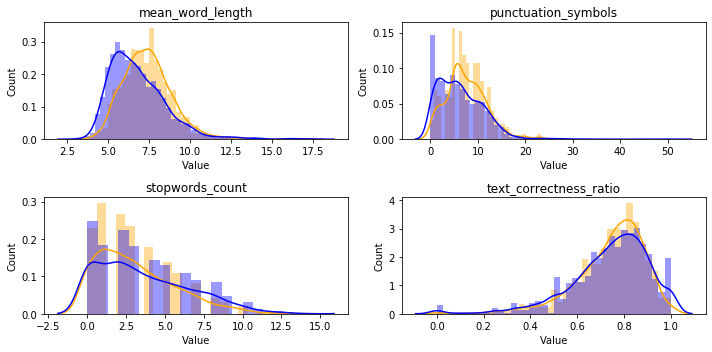

In [28]:
# Plot the found features

features = ['mean_word_length', 'stopwords_count', 'punctuation_symbols', 'text_correctness_ratio']
DISASTER_TWEETS = X_train['target'] == 1
NO_DISASTER_TWEETS = X_train['target'] == 0

fig, (axes1, axes2) = plt.subplots(ncols=len(features)//2, nrows=len(features)//2, figsize=(10, 5))

for i, feature in enumerate(features):
  if feature == 'mean_word_length' or feature == 'punctuation_symbols':
    i = 0
    if feature == 'punctuation_symbols':
      i = 1
    sns.distplot(X_train.loc[DISASTER_TWEETS][feature], label = 'DISASTER', ax = axes1[i], color = 'orange')
    sns.distplot(X_train.loc[NO_DISASTER_TWEETS][feature], label = 'NO DISASTER', ax = axes1[i], color = 'blue')

    axes1[i].set_title('{0}'.format(feature))
    axes1[i].set_xlabel('Value')
    axes1[i].set_ylabel('Count')

  elif feature == 'stopwords_count' or feature == 'text_correctness_ratio':
    i = 0
    if feature == 'text_correctness_ratio':
      i = 1
    sns.distplot(X_train.loc[DISASTER_TWEETS][feature], label = 'DISASTER', ax = axes2[i], color = 'orange')
    sns.distplot(X_train.loc[NO_DISASTER_TWEETS][feature], label = 'NO DISASTER', ax = axes2[i], color = 'blue')

    axes2[i].set_title('{0}'.format(feature))
    axes2[i].set_xlabel('Value')
    axes2[i].set_ylabel('Count')



fig.tight_layout()
plt.show()

In [29]:
# TextBlob: While Vader gives positive/negative, TextBlob returns for each text subjectivity and polarity!

# Turn the raw text into a string
def listToString(s):  
    str1 = ""          # initialize an empty string 
    for ele in s:      # traverse in the string  
        str1 += " "
        str1 += ele      
    return str1        # return string
        
# Create two new features: polarity and sentiment

polarity = []
subjectivity = []

for index, row in X_train.iterrows():
  polarity.append(TextBlob(listToString(row['raw_text'])).sentiment.polarity)
  subjectivity.append(TextBlob(listToString(row['raw_text'])).sentiment.subjectivity)

X_train['polarity'] = polarity
X_train['subjectivity'] = subjectivity

In [30]:
X_train.columns.values

array(['keyword', 'location', 'text', 'target', 'raw_text', 'hashtags',
       'tags', 'links', 'states', 'city', 'country',
       'disaster_words_in_text', 'keyword_disaster_ratio',
       'count_#keywords', 'Top Disaster Hashtags', 'hashtags_number',
       'tags_number', 'hashtags_bool', 'Important words frequency',
       'number_of_words', 'number_of_characters', 'mean_word_length',
       'punctuation_symbols', 'stopwords_count', 'text_correctness_ratio',
       'neg', 'neu', 'pos', 'compound', 'polarity', 'subjectivity'],
      dtype=object)

In [32]:
tmp = X_train.copy(deep=True)
tmp.text = tmp.text.apply(lambda x: ' '.join(x))
tmp.apply(lambda x: x.factorize()[0]).corr()

,keyword,location,text,target,raw_text,hashtags,tags,links,states,city,...,mean_word_length,punctuation_symbols,stopwords_count,text_correctness_ratio,neg,neu,pos,compound,polarity,subjectivity
keyword,1.000000,0.339996,0.973972,-0.045419,0.974020,0.219350,0.268230,-0.000480,0.006042,0.111080,...,0.164476,0.018547,0.005260,0.025842,0.117687,0.141410,0.128753,0.253016,0.050158,0.028849
location,0.339996,1.000000,0.329737,0.022244,0.329295,0.064568,0.159700,-0.079251,-0.011892,0.392614,...,0.061921,-0.032280,0.010025,0.012179,0.065844,0.080186,0.049356,0.136448,-0.005044,-0.048656
text,0.973972,0.329737,1.000000,-0.055176,0.993768,0.232571,0.268795,-0.002579,0.003515,0.106850,...,0.169355,0.021196,0.004714,0.027618,0.116147,0.134651,0.128934,0.256613,0.043789,0.027709
target,-0.045419,0.022244,-0.055176,1.000000,-0.059273,-0.067633,0.087854,-0.160434,-0.004573,-0.016400,...,0.017280,-0.108486,0.047127,-0.003859,-0.080878,0.027270,0.153189,0.090597,-0.126948,-0.236869
raw_text,0.974020,0.329295,0.993768,-0.059273,1.000000,0.231355,0.265573,-0.002837,0.000180,0.105897,...,0.166662,0.021424,0.004155,0.025528,0.118631,0.136534,0.123806,0.253027,0.048686,0.029732
hashtags,0.219350,0.064568,0.232571,-0.067633,0.231355,1.000000,-0.002448,0.100049,0.010478,0.041265,...,0.089035,0.220495,-0.060228,0.065912,-0.019310,0.008500,0.014151,0.022672,0.071299,0.140145
tags,0.268230,0.159700,0.268795,0.087854,0.265573,-0.002448,1.000000,-0.207438,0.027467,0.035244,...,0.028724,-0.066602,0.019456,0.040836,0.049380,0.099734,0.105248,0.157169,-0.101655,-0.234546
links,-0.000480,-0.079251,-0.002579,-0.160434,-0.002837,0.100049,-0.207438,1.000000,-0.000344,0.004201,...,0.071015,0.617887,-0.185453,0.009434,-0.094981,-0.118401,-0.128037,-0.168630,0.383933,0.740975
states,0.006042,-0.011892,0.003515,-0.004573,0.000180,0.010478,0.027467,-0.000344,1.000000,0.086605,...,0.018560,0.007097,0.006949,0.011908,-0.000868,0.039513,0.044919,0.019050,0.000867,0.020718
city,0.111080,0.392614,0.106850,-0.016400,0.105897,0.041265,0.035244,0.004201,0.086605,1.000000,...,0.025002,0.020993,-0.017792,0.007462,-0.003222,0.017380,0.024835,0.027017,0.036370,0.038128


# Data Exploration - test set

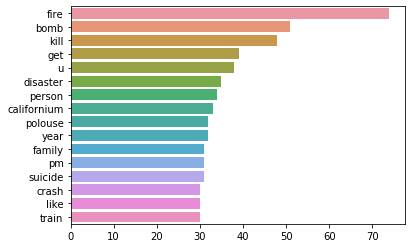

In [33]:
# LOCATION:
# Create city and country features
X_test['city'] = X_test.apply(lambda x: GeoText(x['location']).cities[0] if type(x['location']) != float and len(GeoText(x['location']).cities) > 0 else np.nan, axis=1)
X_test['country'] = X_test.apply(lambda x: GeoText(x['location']).countries[0] if type(x['location']) != float and len(GeoText(x['location']).countries) > 0 else np.nan, axis=1)

# KEYWORDS:
# No of keywords/tweet as a new feature

X_test['keyword'].fillna('nan', inplace=True)
X_test['disaster_words_in_text'] = 0

keywords = X_test['keyword'].unique()
no_of_keywords = []

for index, row in X_test.iterrows():
  count = 0
  for word in keywords:
    if word in row['raw_text']:
      count = count+1
  no_of_keywords.append(count)

X_test['disaster_words_in_text'] = no_of_keywords

# How likely it is that a keyword is actually associated with a real disaster
X_test['keyword_disaster_ratio'] = float('nan')

for index, row in X_test.iterrows():
  if row.keyword != 'nan':
    ratio = X_test.loc[np.logical_and(X_test.target == 1, X_test.keyword == row.keyword)].shape[0] / (X_test.loc[np.logical_and(X_test.target == 1, X_test.keyword == row.keyword)].shape[0] + X_test.loc[np.logical_and(X_test.target == 0, X_test.keyword == row.keyword)].shape[0])
    X_test['keyword_disaster_ratio'][index] = ratio

X_test['keyword_disaster_ratio'].fillna(0.5, inplace = True)

# Feature: Count Keywords of Tweets in hashtags
keywords = list(X_test['keyword'].value_counts().index)
keywords.pop(0)
for i in range(len(keywords)):
    keywords[i] = keywords[i].replace(' ', '')

list_hashtag = []
for i in range(len(X_test['hashtags'])):
  hashtags = X_test['hashtags'].iloc[i]
  hashtags = hashtags.split(',')
  list_hashtags = []
  count = 0
  for l in range(len(hashtags)):
    hashtags[l] = hashtags[l].replace('#', '')
    hashtags[l] = hashtags[l].replace('}', '')
    hashtags[l] = hashtags[l].replace('{', '')
    hashtags[l] = hashtags[l].replace(',', '')
    list_hashtags.append(hashtags[l])
    for k in range(len(list_hashtags)):
      for j in range(len(keywords)):
        if keywords[j] == list_hashtags[k]:
          count = count + 1
  list_hashtag.append(count)

X_test['count_#keywords'] = list_hashtag

# HASHTAG:
# Find the hashtags that are used 100% in a disaster tweet
# Could be a usefull feature

vectorizer_hashtags = CountVectorizer(min_df = 5)
hashtags_vec = vectorizer_hashtags.fit_transform(X_test['hashtags'])
X_test_hashtags = pd.DataFrame(hashtags_vec.toarray(), columns=vectorizer_hashtags.get_feature_names())

new_dataframe = X_test['target'].reset_index()
new_dataframe.drop(columns = ['id'], inplace = True)
X_test_hashtags.sum(axis=0)

top_hashtags = (X_test_hashtags.transpose().dot(new_dataframe.T.squeeze()) / X_test_hashtags.sum(axis = 0)).sort_values(ascending=False)
top_disaster_htags = list(top_hashtags[top_hashtags == 1].index)

X_test['Top Disaster Hashtags'] = 0

for index, htag in enumerate(X_test['hashtags']):
  count = 0
  for top_htag in top_disaster_htags:
    if htag is not None and htag == top_htag:
      count+= 1
      X_test['Top Disaster Hashtags'].iloc[index] = count

# Hashtag count

X_test['hashtags_number'] = 0
for index, row in X_test.iterrows():
  X_test['hashtags_number'][index] = len(row.hashtags.split())

X_test['tags_number'] = 0
for index, row in X_test.iterrows():
  X_test['tags_number'][index] = len(row.tags.split())

# Feature: Bool Hashtags -- Does having a hashtag affect the disaster status?
list_bool = []
for i in range(len(X_test['hashtags'])):
  if bool(X_test['hashtags'].iloc[i]):
    list_bool.append(1)
  else:
    list_bool.append(0)
X_test['hashtags_bool'] = list_bool
X_test['target'].corr(X_test['hashtags_bool'])

# TEXT:
# Most used words when target == 1
list_of_words = []
for sentence in X_test.loc[X_test.target == 1, 'text']:
  for word in sentence:
    list_of_words.append(word)
word_frequency = FreqDist(list_of_words)
used_words = list(word_frequency.most_common())[:16]
sns.barplot([x[1] for x in used_words], [x[0] for x in used_words])

# Finding most used words when target == 1 and add the number of words that appear in every tweet to a new column
count_most_used_words = []
for index,sentence in enumerate(X_test.text):
  for word in [x[0] for x in used_words]:
    if word in sentence:
      count_most_used_words.append((index, sentence.count(word)))

X_test['Important words frequency'] = 0
for index, value in enumerate(X_test['Important words frequency']):
  for word_index, value2 in count_most_used_words:
    if word_index == index:
      X_test['Important words frequency'].iloc[index] = value2

# Word count of text / How many words there are in each text
X_test['number_of_words'] = 0

count = X_test['raw_text'].str.split().apply(len)
X_test['number_of_words'] = count

# No. of characters per tweet
X_test['number_of_characters'] = 0
for index, row in X_test.iterrows():
  X_test['number_of_characters'][index] = len(row.raw_text)

# Mean word length / The mean length of words in each text
X_test['mean_word_length'] = 0.00
for index, row in X_test.iterrows():
  X_test['mean_word_length'][index] = len(row.raw_text) / row.number_of_words

# Count punctuation symbols per tweet:

X_test['punctuation_symbols'] = 0
for index, row in X_test.iterrows():
  for character in row.raw_text:
    if character in string.punctuation:
      X_test['punctuation_symbols'][index] += 1

# Count stop words per tweet:
X_test['stopwords_count'] = 0
for index, row in X_test.iterrows():
  for word in stop_words:
    if word in row.raw_text.split():
      X_test['stopwords_count'][index] +=1

# How much of the tweet is gramatically

spell = SpellChecker()

for index, row in X_test.iterrows():
  X_test['tags_number'][index] = len(row.tags.split())

grammar_nazi = []
for index, row in X_test.iterrows():
  tweet = row.raw_text.split()
  length_of_tweet = len(tweet)
  spelling_errors = len(spell.unknown(tweet))
  correctness_ratio = (length_of_tweet - spelling_errors) / length_of_tweet
  grammar_nazi.append(correctness_ratio)

X_test['text_correctness_ratio'] = grammar_nazi

# SENTIMENT ANALYSIS WITH VADER

list_score = []
analyzer = SentimentIntensityAnalyzer()
for i in range(len(X_test['raw_text'])):
    score = analyzer.polarity_scores(X_test['raw_text'].iloc[i])
    list_score.append(score)


#list_score[0]['neg']
list_neg = []
list_neu = []
list_pos = []
list_compound = []
for i in range(len(list_score)):
    list_neg.append(list_score[i]['neg'])
    list_neu.append(list_score[i]['neu'])
    list_pos.append(list_score[i]['pos'])
    list_compound.append(list_score[i]['compound'])
X_test['neg'] = list_neg
X_test['neu'] = list_neu
X_test['pos'] = list_pos
X_test['compound'] = list_compound

# TextBlob: While Vader gives positive/negative, TextBlob returns for each text subjectivity and polarity!

# Turn the raw text into a string
def listToString(s):  
    str1 = ""          # initialize an empty string 
    for ele in s:      # traverse in the string  
        str1 += " "
        str1 += ele      
    return str1        # return string
        
# Create two new features: polarity and sentiment

polarity = []
subjectivity = []

for index, row in X_test.iterrows():
  polarity.append(TextBlob(listToString(row['raw_text'])).sentiment.polarity)
  subjectivity.append(TextBlob(listToString(row['raw_text'])).sentiment.subjectivity)

X_test['polarity'] = polarity
X_test['subjectivity'] = subjectivity

# Models - SVM



In [34]:
# X_train
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate

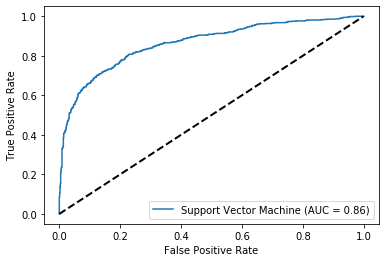

SVM Accuracy Score ->  79.68354430379748
SVM recall Score ->  78.9983844911147
SVM Precision Score ->  71.91176470588235
SVM F1 Score ->  75.28868360277136


In [35]:
from sklearn import svm, model_selection
from sklearn.svm import SVC 

data_model = X_train[['links', 'keyword_disaster_ratio', 'Important words frequency', 'number_of_words', 'number_of_characters', 'punctuation_symbols', 'tags_number', 'neg', 'neu', 'pos', 'polarity', 'subjectivity', 'text_correctness_ratio', 'Top Disaster Hashtags']]

TFIDF_vec = TfidfVectorizer(max_features=10000)
TFIDF_vec.fit([' '.join(element) for element in X_train['text']])

TFIDF = TFIDF_vec.transform([' '.join(element) for element in X_train['text']])
TFIDF_df = pd.DataFrame.sparse.from_spmatrix(TFIDF,columns=TFIDF_vec.get_feature_names())

TFIDF_df['id'] = data_model.index
TFIDF_df.set_index('id', inplace = True)
new_df = pd.concat([data_model, TFIDF_df], axis = 1)


Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(new_df, X_train['target'],test_size=0.3)


SVM = svm.SVC(C=5000, kernel='rbf', gamma=0.0001)
SVM.fit(Train_X,Train_Y)
svc_disp = plot_roc_curve(SVM, Test_X, Test_Y, name = "Support Vector Machine")
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.show()
predictions_SVM = SVM.predict(Test_X)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
print("SVM recall Score -> ",recall_score(predictions_SVM, Test_Y)*100)
print("SVM Precision Score -> ", precision_score(predictions_SVM, Test_Y)*100)
print("SVM F1 Score -> ", f1_score(predictions_SVM, Test_Y)*100)

C:\Users\roxan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


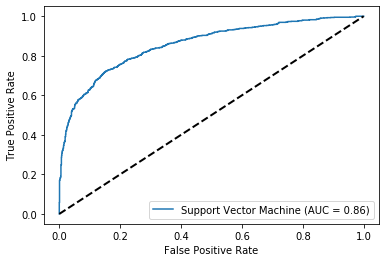

SVM Accuracy Score - Final ->  79.2693661971831
SVM recall Score - Final ->  78.76004592422503
SVM Precision Score ->  70.57613168724279
SVM F1 Score ->  74.44384156266956


<Figure size 432x288 with 0 Axes>

In [36]:
Y_test = X_test['target'].to_frame()
Y_train = X_train['target'].to_frame()

data_test = X_test[['links', 'keyword_disaster_ratio', 'Important words frequency', 'number_of_words', 'number_of_characters', 'punctuation_symbols', 'tags_number', 'neg', 'neu', 'pos', 'polarity', 'subjectivity', 'text_correctness_ratio', 'Top Disaster Hashtags']]

TFIDF_vec_test = TfidfVectorizer(max_features=10000)
TFIDF_vec_test.fit([' '.join(element) for element in X_test['text']])

TFIDF = TFIDF_vec_test.transform([' '.join(element) for element in X_test['text']])
TFIDF_df_test = pd.DataFrame.sparse.from_spmatrix(TFIDF,columns=TFIDF_vec_test.get_feature_names())

TFIDF_df_test['id'] = data_test.index
TFIDF_df_test.set_index('id', inplace = True)
final_df = pd.concat([data_model, TFIDF_df_test], axis = 1) 


SVM = svm.SVC(C=5000, kernel='rbf', gamma=0.0001)

SVM.fit(data_model, Y_train)
svc_disp = plot_roc_curve(SVM, data_test, Y_test, name = "Support Vector Machine")
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.show()
plt.savefig("plot.jpg", bbox_inches='tight')
predictions = SVM.predict(data_test)
print("SVM Accuracy Score - Final -> ",accuracy_score(predictions, Y_test)*100)
print("SVM recall Score - Final -> ",recall_score(predictions, Y_test)*100)
print("SVM Precision Score -> ", precision_score(predictions, Y_test)*100)
print("SVM F1 Score -> ", f1_score(predictions, Y_test)*100)

------

## BAYES

In [37]:
# Importing everything needed
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

In [38]:
Y_train = X_train['target'].to_frame()
print(type(Y_train))

<class 'pandas.core.frame.DataFrame'>


In [39]:
# TF-IDF feature

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    max_features = 700,
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

tfidf_feature = tfidf.fit_transform(X_train['text'])
tfidf_feature = pd.DataFrame(tfidf_feature.toarray(), columns = tfidf.get_feature_names())

tfidf_test = tfidf.transform(X_test['text'])
tfidf_test = pd.DataFrame(tfidf_test.toarray(), columns = tfidf.get_feature_names())

In [40]:

# DATA FOR MODEL: numerical features and tfidf
data_train = X_train[['links', 'disaster_words_in_text', 'keyword_disaster_ratio', 'Important words frequency', 'number_of_words', 'number_of_characters', 'mean_word_length', 'punctuation_symbols', 'stopwords_count', 'hashtags_number', 'tags_number', 'neg', 'neu', 'pos', 'compound', 'polarity', 'subjectivity', 'text_correctness_ratio']]


index_tfidf = data_train.index
tfidf_feature['id'] = index_tfidf
tfidf_feature.set_index('id', inplace = True)
data_train = pd.concat([data_train, tfidf_feature], axis = 1)
# data_train

In [41]:
# One-Hot Encoding of categorical data
# 'states', 'city', 'country', 'keyword'

# Create new columns for one hot encoding:

# FOR STATE:
values = array(X_train['states'])

states_dummies = pd.DataFrame({'state:': list(values)})
categorical_features = pd.get_dummies(states_dummies,prefix=['state'], drop_first=True)
categorical_features['id'] = data_train.index
categorical_features.set_index('id', inplace = True)
categorical_features

# FOR CITY:
values = array(X_train['city'])

city_dummies = pd.DataFrame({'city:': list(values)})
city_feature = pd.get_dummies(city_dummies,prefix=['city'], drop_first=True)
city_feature['id'] = data_train.index
city_feature.set_index('id', inplace = True)
city_feature

# FOR COUNTRY:
values = array(X_train['country'])

country_dummies = pd.DataFrame({'country:': list(values)})
country_feature = pd.get_dummies(country_dummies,prefix=['country'], drop_first=True)
country_feature['id'] = data_train.index
country_feature.set_index('id', inplace = True)
country_feature

# FOR KEYWORD:
values = array(X_train['keyword'])

keyword_dummies = pd.DataFrame({'keyword:': list(values)})
keyword_feature = pd.get_dummies(keyword_dummies,prefix=['keyword'], drop_first=True)
keyword_feature['id'] = data_train.index
keyword_feature.set_index('id', inplace = True)
keyword_feature



categorical_features = pd.concat([categorical_features, city_feature], axis = 1)
categorical_features = pd.concat([categorical_features, country_feature], axis = 1)
categorical_features = pd.concat([categorical_features, keyword_feature], axis = 1)
categorical_features

data_train = pd.concat([data_train, categorical_features], axis = 1)
# data_train

In [42]:
# Hashtags dummies
# Because there are many hashtags that do not represent words in the english dictionary,
# they were spell checked before computing the dummy variables

spell = SpellChecker()

values = X_train.apply(lambda x: x['hashtags'].split(), axis = 1)

real_hashtags = []
for hashtags in values:
  real_hashtags.append(set(hashtags).difference(set(spell.unknown(hashtags))))

mlb = MultiLabelBinarizer()
array_out = mlb.fit_transform(real_hashtags)

hashtags_dummies = pd.DataFrame(data = array_out, columns = mlb.classes_)
hashtags_dummies['id'] = data_train.index
hashtags_dummies.set_index('id', inplace = True)

data_train = pd.concat([data_train, hashtags_dummies], axis = 1)

In [43]:
copy = data_train.copy()
copy2 = Y_train.copy()


In [44]:
data_train = copy.copy()
Y_train = copy2.copy()

In [45]:
data_train.reset_index(inplace = True)
data_train.drop(columns=['id'], inplace = True)

Y_train.reset_index(inplace = True)
Y_train.drop(columns=['id'], inplace = True)
Y_train = Y_train.values.ravel()

In [46]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.model_selection import cross_val_predict
import statistics

Accuracy:  [0.7607, 0.7588, 0.7417, 0.7388, 0.7607]
Precision:  [0.7271, 0.7033, 0.7079, 0.7112, 0.7329]
Recall:  [0.7044, 0.7533, 0.6733, 0.6526, 0.6904]
f1 score:  [0.7156, 0.7275, 0.6902, 0.6806, 0.711]
Accuracy mean:  0.7521
Precision mean:  0.7165
Recall mean:  0.6948
f1 score mean:  0.7050


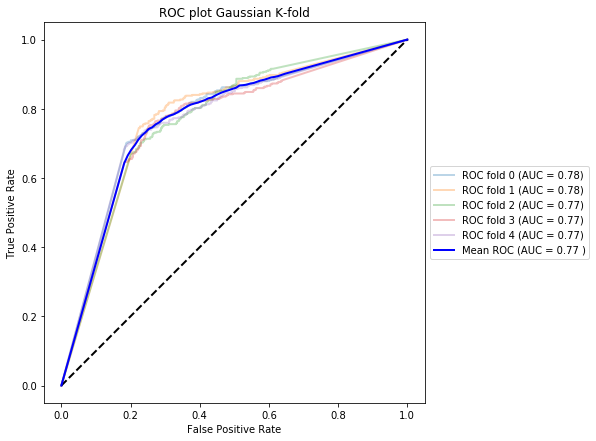

In [47]:
# 1 Gaussian Naive Bayes: Stratified K-Fold with ROC plot
from sklearn.metrics import log_loss
from numpy import interp

k_fold_stratified = StratifiedKFold(n_splits=5, shuffle = True)
f_fold_gnb = GaussianNB()

accuracy_list, precision_list, recall_list, f1_score_list, log_loss = [], [], [], [], []

fig1 = plt.figure(figsize=[7,7])
ax1 = fig1.add_subplot(111,aspect = 'equal')

tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)

i=0
for train_index, test_index in k_fold_stratified.split(data_train, Y_train):
  x_train, x_test = data_train.iloc[train_index], data_train.iloc[test_index]
  y_train, y_test = Y_train[train_index], Y_train[test_index]

  f_fold_gnb.fit(x_train, y_train)

  y_pred = f_fold_gnb.predict_proba(x_test)

  accuracy_list.append(round(accuracy_score(y_test, y_pred[:,1].round()),4))
  precision_list.append(round(precision_score(y_test, y_pred[:,1].round()),4))
  recall_list.append(round(recall_score(y_test, y_pred[:,1].round()),4))
  f1_score_list.append(round(f1_score(y_test, y_pred[:,1].round()),4))

  fpr, tpr, t = roc_curve(y_test, y_pred[:,1])
  tprs.append(interp(mean_fpr, fpr, tpr))
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
  i= i+1

print("Accuracy: ", accuracy_list)
print("Precision: ", precision_list)
print("Recall: ", recall_list)
print("f1 score: ", f1_score_list)

print("Accuracy mean: ", "%.4f" % statistics.mean(accuracy_list))
print("Precision mean: ", "%.4f" % statistics.mean(precision_list))
print("Recall mean: ", "%.4f" % statistics.mean(recall_list))
print("f1 score mean: ", "%.4f" % statistics.mean(f1_score_list))


plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

mean_tpr_gaussian = mean_tpr
mean_auc_gaussian = mean_auc
mean_fpr_gaussian = mean_fpr

plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC plot Gaussian K-fold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


Accuracy:  [0.7844, 0.7968, 0.7816, 0.8015, 0.7863]
Precision:  [0.7794, 0.798, 0.7709, 0.7913, 0.7732]
Recall:  [0.6911, 0.7022, 0.6956, 0.7261, 0.706]
f1 score:  [0.7326, 0.747, 0.7313, 0.7573, 0.7381]
Accuracy mean:  0.7901
Precision mean:  0.7826
Recall mean:  0.7042
f1 score mean:  0.7413


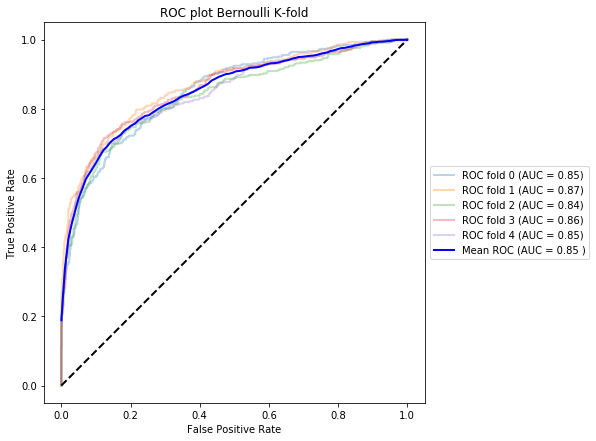

In [48]:
# 2 Bernoulli Naive Bayes: Stratified K-Fold

k_fold_stratified = StratifiedKFold(n_splits=5, shuffle = True)
f_fold_bnb = BernoulliNB()

accuracy_list, precision_list, recall_list, f1_score_list = [], [], [], []

fig2 = plt.figure(figsize=[7,7])
ax2 = fig2.add_subplot(111,aspect = 'equal')

tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)

i=0
for train_index, test_index in k_fold_stratified.split(data_train, Y_train):
  x_train, x_test = data_train.iloc[train_index], data_train.iloc[test_index]
  y_train, y_test = Y_train[train_index], Y_train[test_index]

  f_fold_bnb.fit(x_train, y_train)

  y_pred = f_fold_bnb.predict_proba(x_test)

  accuracy_list.append(round(accuracy_score(y_test, y_pred[:,1].round()),4))
  precision_list.append(round(precision_score(y_test, y_pred[:,1].round()),4))
  recall_list.append(round(recall_score(y_test, y_pred[:,1].round()),4))
  f1_score_list.append(round(f1_score(y_test, y_pred[:,1].round()),4))

  fpr, tpr, t = roc_curve(y_test, y_pred[:,1])
  tprs.append(interp(mean_fpr, fpr, tpr))
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
  i= i+1

print("Accuracy: ", accuracy_list)
print("Precision: ", precision_list)
print("Recall: ", recall_list)
print("f1 score: ", f1_score_list)

print("Accuracy mean: ", "%.4f" % statistics.mean(accuracy_list))
print("Precision mean: ", "%.4f" % statistics.mean(precision_list))
print("Recall mean: ", "%.4f" % statistics.mean(recall_list))
print("f1 score mean: ", "%.4f" % statistics.mean(f1_score_list))


plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

mean_tpr_bernoulli = mean_tpr
mean_auc_bernoulli = mean_auc
mean_fpr_bernoulli = mean_fpr
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC plot Bernoulli K-fold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

C:\Users\roxan\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Accuracy:  [0.8082, 0.7977, 0.7673, 0.7996, 0.8139]
Precision:  [0.7897, 0.7855, 0.7662, 0.7755, 0.7976]
Recall:  [0.7511, 0.7244, 0.6556, 0.7461, 0.755]
f1 score:  [0.7699, 0.7538, 0.7066, 0.7605, 0.7757]
Accuracy mean:  0.7973
Precision mean:  0.7829
Recall mean:  0.7264
f1 score mean:  0.7533


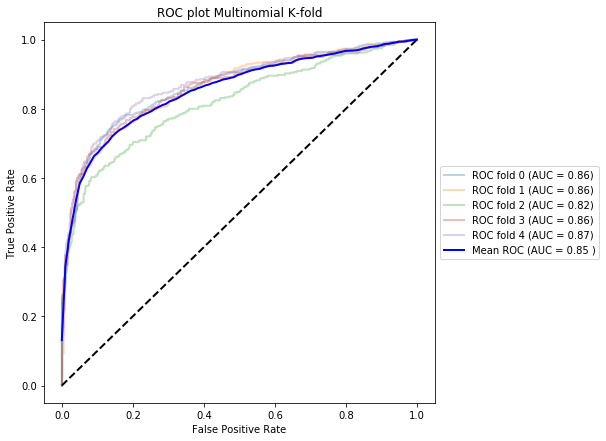

In [49]:
# 3 Multinomial Naive Bayes: Stratified K-Fold + CountVectorizer
data_train_mul = data_train.drop(columns = ['compound', 'polarity', 'subjectivity']).copy() # Because Multinomial NB does not accept negative values!
vect = CountVectorizer(strip_accents='ascii', token_pattern=r'(?:\b[\w#!@]+\b)',analyzer='word',max_df=0.1,max_features=3500, lowercase=True)
x_cv = vect.fit_transform(X_train['raw_text'])

count_vect_df = pd.DataFrame(x_cv.todense(), columns=vect.get_feature_names())
count_vect_df['id'] = data_train.index
count_vect_df.set_index('id', inplace = True)

new_df = pd.concat([data_train_mul, count_vect_df], axis = 1)


k_fold_stratified = StratifiedKFold(n_splits=5, shuffle = True)
f_fold_mnb = MultinomialNB()

accuracy_list, precision_list, recall_list, f1_score_list = [], [], [], []

fig3 = plt.figure(figsize=[7,7])
ax3 = fig1.add_subplot(111,aspect = 'equal')

tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)

i=0
for train_index, test_index in k_fold_stratified.split(new_df, Y_train):
  x_train, x_test = new_df.iloc[train_index], new_df.iloc[test_index]
  y_train, y_test = Y_train[train_index], Y_train[test_index]

  f_fold_mnb.fit(x_train, y_train)

  y_pred = f_fold_mnb.predict_proba(x_test)

  accuracy_list.append(round(accuracy_score(y_test, y_pred[:,1].round()),4))
  precision_list.append(round(precision_score(y_test, y_pred[:,1].round()),4))
  recall_list.append(round(recall_score(y_test, y_pred[:,1].round()),4))
  f1_score_list.append(round(f1_score(y_test, y_pred[:,1].round()),4))

  fpr, tpr, t = roc_curve(y_test, y_pred[:,1])
  tprs.append(interp(mean_fpr, fpr, tpr))
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
  i= i+1

print("Accuracy: ", accuracy_list)
print("Precision: ", precision_list)
print("Recall: ", recall_list)
print("f1 score: ", f1_score_list)

print("Accuracy mean: ", "%.4f" % statistics.mean(accuracy_list))
print("Precision mean: ", "%.4f" % statistics.mean(precision_list))
print("Recall mean: ", "%.4f" % statistics.mean(recall_list))
print("f1 score mean: ", "%.4f" % statistics.mean(f1_score_list))


plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

mean_tpr_multinomial = mean_tpr
mean_auc_multinomial = mean_auc
mean_fpr_multinomial = mean_fpr
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC plot Multinomial K-fold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Bayes - final results

In [50]:
# Preparing the data of the test set

Y_test = X_test['target'].to_frame()
print(type(Y_test))

# TF-IDF feature

# DATA FOR MODEL: numerical features and tfidf
data_test = X_test[['links', 'disaster_words_in_text', 'keyword_disaster_ratio', 'Important words frequency', 'number_of_words', 'number_of_characters', 'mean_word_length', 'punctuation_symbols', 'stopwords_count', 'hashtags_number', 'tags_number', 'neg', 'neu', 'pos', 'compound', 'polarity', 'subjectivity', 'text_correctness_ratio']]

index_tfidf = data_test.index
tfidf_test['id'] = index_tfidf
tfidf_test.set_index('id', inplace = True)
data_test = pd.concat([data_test, tfidf_test], axis = 1)
# data_test

# One-Hot Encoding of categorical data
# 'states', 'city', 'country', 'keyword'

# Create new columns for one hot encoding:

# FOR STATE:
values = array(X_test['states'])

states_dummies = pd.DataFrame({'state:': list(values)})
categorical_features = pd.get_dummies(states_dummies,prefix=['state'], drop_first=True)
categorical_features['id'] = data_test.index
categorical_features.set_index('id', inplace = True)
categorical_features

# FOR CITY:
values = array(X_test['city'])

city_dummies = pd.DataFrame({'city:': list(values)})
city_feature = pd.get_dummies(city_dummies,prefix=['city'], drop_first=True)
city_feature['id'] = data_test.index
city_feature.set_index('id', inplace = True)
city_feature

# FOR COUNTRY:
values = array(X_test['country'])

country_dummies = pd.DataFrame({'country:': list(values)})
country_feature = pd.get_dummies(country_dummies,prefix=['country'], drop_first=True)
country_feature['id'] = data_test.index
country_feature.set_index('id', inplace = True)
country_feature

# FOR KEYWORD:
values = array(X_test['keyword'])

keyword_dummies = pd.DataFrame({'keyword:': list(values)})
keyword_feature = pd.get_dummies(keyword_dummies,prefix=['keyword'], drop_first=True)
keyword_feature['id'] = data_test.index
keyword_feature.set_index('id', inplace = True)
keyword_feature



categorical_features = pd.concat([categorical_features, city_feature], axis = 1)
categorical_features = pd.concat([categorical_features, country_feature], axis = 1)
categorical_features = pd.concat([categorical_features, keyword_feature], axis = 1)
categorical_features

data_test = pd.concat([data_test, categorical_features], axis = 1)
# data_test

# Hashtags dummies
# Because there are many hashtags that do not represent words in the english dictionary,
# they were spell checked before computing the dummy variables

spell = SpellChecker()

values = X_test.apply(lambda x: x['hashtags'].split(), axis = 1)

real_hashtags = []
for hashtags in values:
  real_hashtags.append(set(hashtags).difference(set(spell.unknown(hashtags))))

mlb = MultiLabelBinarizer()
array_out = mlb.fit_transform(real_hashtags)

hashtags_dummies = pd.DataFrame(data = array_out, columns = mlb.classes_)
hashtags_dummies['id'] = data_test.index
hashtags_dummies.set_index('id', inplace = True)

data_test = pd.concat([data_test, hashtags_dummies], axis = 1)


<class 'pandas.core.frame.DataFrame'>


In [51]:
copy3 = data_test.copy()
copy4 = Y_test.copy()

In [52]:
data_test.reset_index(inplace = True)
data_test.drop(columns=['id'], inplace = True)

Y_test.reset_index(inplace = True)
Y_test.drop(columns=['id'], inplace = True)
Y_test = Y_test.values.ravel()

In [53]:
# Because of dummy variables, the train and test data do not have the same number of columns. With align, we only keep the common on!
# In this way, they will fit in the models

final_train, final_test = data_train.align(data_test, join='inner', axis=1)
final_test = final_test.loc[:,~final_test.columns.duplicated()]
final_train = final_train.loc[:,~final_train.columns.duplicated()]

Accuracy:  0.7526
Precision:  0.75
Recall:  0.6327
F1-score:  0.6864
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.786


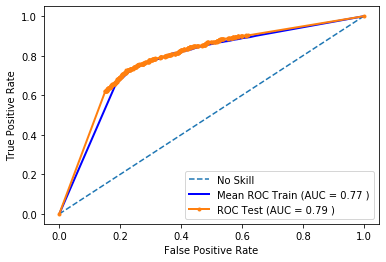

In [54]:
# 1 Gaussian Naive Bayes


# Create ROC plot:
ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = f_fold_gnb.fit(final_train, Y_train).predict_proba(final_test)

lr_probs = lr_probs[:, 1] # keep probabilities for the positive outcome only

print("Accuracy: " , (round(accuracy_score(Y_test, lr_probs.round()),4)))
print("Precision: " , (round(precision_score(Y_test, lr_probs.round()),4)))
print("Recall: " , (round(recall_score(Y_test, lr_probs.round()),4)))
print("F1-score: " , (round(f1_score(Y_test, lr_probs.round()),4)))


ns_auc = roc_auc_score(Y_test, ns_probs) # calculate scores
lr_auc = roc_auc_score(Y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc)) # summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs) # calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill') # plot the roc curve for the model

pyplot.plot(mean_fpr_gaussian, mean_tpr_gaussian, color='blue', label=r'Mean ROC Train (AUC = %0.2f )' % (mean_auc_gaussian),lw=2, alpha=1)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ROC Test (AUC = %0.2f )' % (lr_auc),lw=2, alpha=1)


pyplot.xlabel('False Positive Rate') # axis labels
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()

Accuracy:  0.7887
Precision:  0.7777
Recall:  0.7088
F1-score:  0.7417
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.852


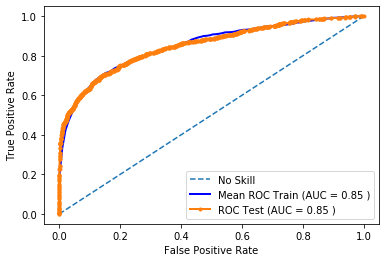

In [55]:
# 2 Bernoulli Naive Bayes

f_fold_bnb.fit(final_train, Y_train)
# Create ROC plot:
ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = f_fold_bnb.predict_proba(final_test)

lr_probs = lr_probs[:, 1] # keep probabilities for the positive outcome only

print("Accuracy: " , (round(accuracy_score(Y_test, lr_probs.round()),4)))
print("Precision: " , (round(precision_score(Y_test, lr_probs.round()),4)))
print("Recall: " , (round(recall_score(Y_test, lr_probs.round()),4)))
print("F1-score: " , (round(f1_score(Y_test, lr_probs.round()),4)))


ns_auc = roc_auc_score(Y_test, ns_probs) # calculate scores
lr_auc = roc_auc_score(Y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc)) # summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs) # calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill') # plot the roc curve for the model

pyplot.plot(mean_fpr_bernoulli, mean_tpr_bernoulli, color='blue', label=r'Mean ROC Train (AUC = %0.2f )' % (mean_auc_bernoulli),lw=2, alpha=1)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ROC Test (AUC = %0.2f )' % (lr_auc),lw=2, alpha=1)


pyplot.xlabel('False Positive Rate') # axis labels
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()

Accuracy:  0.7861
Precision:  0.763
Recall:  0.7253
F1-score:  0.7437
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.851


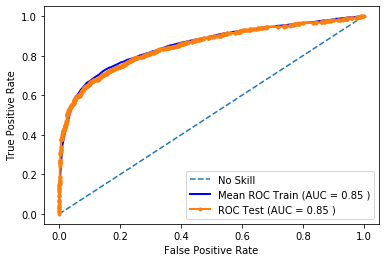

In [56]:
# 3 Multinomial Naive Bayes:  + CountVectorizer

vect = CountVectorizer(strip_accents='ascii', token_pattern=r'(?:\b[\w#!@]+\b)',analyzer='word',max_df=0.1,max_features=3500, lowercase=True)
x_cv = vect.fit_transform(X_train['raw_text'])

count_vect_df = pd.DataFrame(x_cv.todense(), columns=vect.get_feature_names())
count_vect_df['id'] = final_train.index
count_vect_df.set_index('id', inplace = True)

final_train = final_train.drop(columns = ['compound', 'polarity', 'subjectivity']).copy() # Because Multinomial NB does not accept negative values!
final_train_mnb = pd.concat([final_train, count_vect_df], axis = 1)


x_cv_test = vect.fit_transform(X_test['raw_text'])
count_vect_df_test = pd.DataFrame(x_cv_test.todense(), columns=vect.get_feature_names())
count_vect_df_test['id'] = final_test.index
count_vect_df_test.set_index('id', inplace = True)
final_test_mnb = pd.concat([final_test, count_vect_df_test], axis = 1)


final_train_mnb, final_test_mnb = final_train_mnb.align(final_test_mnb, join='inner', axis=1)
final_test_mnb = final_test_mnb.loc[:,~final_test_mnb.columns.duplicated()]
final_train_mnb = final_train_mnb.loc[:,~final_train_mnb.columns.duplicated()]


# Create ROC plot:
ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = f_fold_mnb.fit(final_train_mnb, Y_train).predict_proba(final_test_mnb)

lr_probs = lr_probs[:, 1] # keep probabilities for the positive outcome only

print("Accuracy: " , (round(accuracy_score(Y_test, lr_probs.round()),4)))
print("Precision: " , (round(precision_score(Y_test, lr_probs.round()),4)))
print("Recall: " , (round(recall_score(Y_test, lr_probs.round()),4)))
print("F1-score: " , (round(f1_score(Y_test, lr_probs.round()),4)))


ns_auc = roc_auc_score(Y_test, ns_probs) # calculate scores
lr_auc = roc_auc_score(Y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc)) # summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs) # calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill') # plot the roc curve for the model

pyplot.plot(mean_fpr_multinomial, mean_tpr_multinomial, color='blue', label=r'Mean ROC Train (AUC = %0.2f )' % (mean_auc_multinomial),lw=2, alpha=1)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ROC Test (AUC = %0.2f )' % (lr_auc),lw=2, alpha=1)


pyplot.xlabel('False Positive Rate') # axis labels
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()

# MARKOV CHAIN - 0

In [57]:
# Markov chain works on the principle that, for each tweet, we compute the probability
# it is a disaster, and a nondisaster. Choose the class for which the probability is bigger:
# P(disaster / 'word1, word2, word3, ...') = P('word1, word2, word3, ...' / disaster) * P(disaster)   which for 0-order Markov Chain is eventually:
# P(word1 / disaster) * P(word2 / disaster) * P(word3 / disaster) * ... * P(disaster)
# You calculate P(word / disaster) by dividing the number of disasters in which word accurs by the total number of disasters

# Calculate probability of disaster and nondisaster
# Also, calculate how many tweets we have for disasters and nondisasters

disaster_tweets = X_train[X_train['target'] == 1]['target'].value_counts().item()
nondisaster_tweets = X_train[X_train['target'] == 0]['target'].value_counts().item()
probability_disaster = X_train[X_train['target'] == 1]['target'].value_counts().item() / X_train.shape[0]
probability_non_disaster = X_train[X_train['target'] == 0]['target'].value_counts().item() / X_train.shape[0]

# Dictionaries with all words and how many times they occur in disasters / nondisasters
vocabulary_disaster = {}
vocabulary_nondisaster = {}
for index, row in X_train.iterrows():
  tweet = row.text
  for word in tweet:
    if row.target == 1:
      if word in vocabulary_disaster:
        vocabulary_disaster[word] += 1
      else:
        vocabulary_disaster[word] = 1
      if word not in vocabulary_nondisaster:
        vocabulary_nondisaster[word] = 0
    elif row.target == 0:
      if word in vocabulary_nondisaster:
        vocabulary_nondisaster[word] += 1
      else:
        vocabulary_nondisaster[word] = 1
      if word not in vocabulary_disaster:
        vocabulary_disaster[word] = 0

probability_vocabulary = pd.DataFrame(index = [*vocabulary_disaster], columns=['P(word/disaster)', 'P(word/nondisaster)'])

# Calculate the probability of each word given a disaster or a nondisaster
for index, row in probability_vocabulary.iterrows():
  probability_vocabulary.at[index, 'P(word/disaster)'] = vocabulary_disaster[index]/disaster_tweets
  probability_vocabulary.at[index, 'P(word/nondisaster)'] = vocabulary_nondisaster[index]/nondisaster_tweets

probability_vocabulary

,P(word/disaster),P(word/nondisaster)
deed,0.00044484,0.000331455
reason,0.00266904,0.00530328
may,0.0169039,0.00894929
allah,0.00133452,0
forgive,0.00044484,0.00132582
...,...,...
forney,0.00044484,0
symptom,0.00044484,0
ebike,0.00088968,0
portugal,0.00044484,0


In [58]:
# Having probabilities for all words, calculate the 0-order Markov Chain probability of each tweet
# Choose the class that has the highest probability and append it to the class_probability list
class_probability = []
for index, row in X_train.iterrows():
  tweet = row.text
  disaster_prob = 1
  nondisaster_prob = 1
  for word in tweet:
    if(probability_vocabulary.at[word, 'P(word/disaster)'] != 0):
      disaster_prob = disaster_prob * probability_vocabulary.at[word, 'P(word/disaster)']
    else:
      disaster_prob = disaster_prob * (probability_vocabulary.at[word, 'P(word/nondisaster)'] % 2)
    if(probability_vocabulary.at[word, 'P(word/nondisaster)'] != 0):
      nondisaster_prob = nondisaster_prob * probability_vocabulary.at[word, 'P(word/nondisaster)']
    else:
      nondisaster_prob = nondisaster_prob * (probability_vocabulary.at[word, 'P(word/disaster)'] % 2)
  disaster_prob = disaster_prob * probability_disaster
  nondisaster_prob = nondisaster_prob * probability_non_disaster
  if(disaster_prob >= nondisaster_prob):
    class_probability.append(1)
  else:
    class_probability.append(0)


In [59]:
# Use this list as a feature

X_train['markov_chain_prediction'] = class_probability
my_feature = X_train[['markov_chain_prediction']]
my_feature

,markov_chain_prediction
id,
1,0
4,1
5,1
6,1
7,0
...,...
10866,1
10869,1
10870,1


Accuracy:  0.8184
Precision:  0.8156
Recall:  0.8149
f1 score:  0.8152
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.815


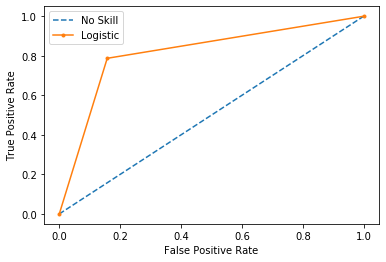

In [60]:
# 2a. Bernoulli Naive Bayes
# Use Bernoulli and predicts the classes
# The binomial model is useful if your feature vectors are binary (i.e. zeros and ones). 
# One application would be text classification with ‘bag of words’ model where the 1s & 0s 
# are “word occurs in the document” and “word does not occur in the document” respectively.


Xtrain, Xtest, ytrain, ytest = train_test_split(my_feature, Y_train, test_size=0.3)
bnb = BernoulliNB()
y_pred = bnb.fit(Xtrain, ytrain).predict(Xtest)

# USE macro:
print("Accuracy: ", "%.4f" % accuracy_score(ytest, y_pred))
print("Precision: ", "%.4f" % precision_score(ytest, y_pred, average = 'macro'))
print("Recall: ", "%.4f" % recall_score(ytest, y_pred, average = 'macro'))
print("f1 score: ", "%.4f" % f1_score(ytest, y_pred, average = 'macro'))

# Create ROC plot:
ns_probs = [0 for _ in range(len(ytest))]
lr_probs = bnb.predict_proba(Xtest)

lr_probs = lr_probs[:, 1] # keep probabilities for the positive outcome only

ns_auc = roc_auc_score(ytest, ns_probs) # calculate scores
lr_auc = roc_auc_score(ytest, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc)) # summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs) # calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(ytest, lr_probs)

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill') # plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
mean_tpr_markov = lr_tpr
mean_auc_markov = lr_auc
mean_fpr_markov = lr_fpr

pyplot.xlabel('False Positive Rate') # axis labels
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()

## Markov Chain - 0 Results

In [61]:
# Having probabilities for all words, calculate the 0-order Markov Chain probability of each tweet
# Choose the class that has the highest probability and append it to the class_probability list
class_probability_test = []
for index, row in X_test.iterrows():
  tweet = row.text
  disaster_prob = 1
  nondisaster_prob = 1
  for word in tweet:
    if word in probability_vocabulary.index:
      if(probability_vocabulary.at[word, 'P(word/disaster)'] != 0):
        disaster_prob = disaster_prob * probability_vocabulary.at[word, 'P(word/disaster)']
      else:
        disaster_prob = disaster_prob * (probability_vocabulary.at[word, 'P(word/nondisaster)'] % 2)
      if(probability_vocabulary.at[word, 'P(word/nondisaster)'] != 0):
        nondisaster_prob = nondisaster_prob * probability_vocabulary.at[word, 'P(word/nondisaster)']
      else:
        nondisaster_prob = nondisaster_prob * (probability_vocabulary.at[word, 'P(word/disaster)'] % 2)
    elif word not in probability_vocabulary.index:
      disaster_prob = disaster_prob * probability_disaster
      nondisaster_prob = nondisaster_prob * probability_non_disaster
  disaster_prob = disaster_prob * probability_disaster
  nondisaster_prob = nondisaster_prob * probability_non_disaster
  if(disaster_prob >= nondisaster_prob):
    class_probability_test.append(1)
  else:
    class_probability_test.append(0)

In [62]:
X_test['markov_chain_prediction'] = class_probability_test
my_feature_test = X_test[['markov_chain_prediction']]

my_feature_test

,markov_chain_prediction
id,
10,1
16,1
17,0
26,1
32,0
...,...
10835,1
10839,1
10842,1


Accuracy:  0.7672
Precision:  0.7291
Recall:  0.7253
F1-score:  0.7272
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.762


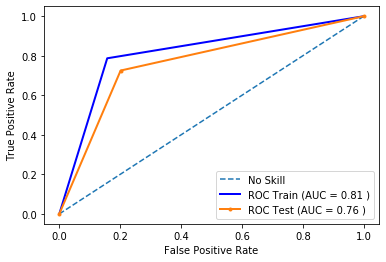

In [63]:
# 2 Bernoulli Naive Bayes

# Create ROC plot:
ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = f_fold_bnb.fit(my_feature, Y_train).predict_proba(my_feature_test)

lr_probs = lr_probs[:, 1] # keep probabilities for the positive outcome only

print("Accuracy: " , (round(accuracy_score(Y_test, lr_probs.round()),4)))
print("Precision: " , (round(precision_score(Y_test, lr_probs.round()),4)))
print("Recall: " , (round(recall_score(Y_test, lr_probs.round()),4)))
print("F1-score: " , (round(f1_score(Y_test, lr_probs.round()),4)))


ns_auc = roc_auc_score(Y_test, ns_probs) # calculate scores
lr_auc = roc_auc_score(Y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc)) # summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs) # calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill') # plot the roc curve for the model

pyplot.plot(mean_fpr_markov, mean_tpr_markov, color='blue', label=r'ROC Train (AUC = %0.2f )' % (mean_auc_markov),lw=2, alpha=1)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ROC Test (AUC = %0.2f )' % (lr_auc),lw=2, alpha=1)


pyplot.xlabel('False Positive Rate') # axis labels
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()

In [64]:
data_train = copy.copy()
Y_train = copy2.copy()

data_test = copy3.copy()
Y_test = copy4.copy()

----------------

## Neural networks

In [65]:
# tmp = X_train.copy(deep=True)
# tmp.text = tmp.text.apply(lambda x: ' '.join(x))
# tmp.apply(lambda x: x.factorize()[0]).corr()

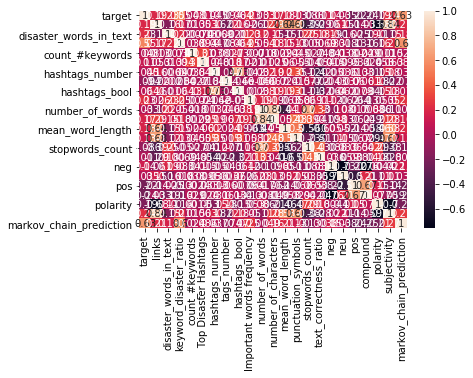

In [66]:
X_train_corr = X_train
corrMatrix = X_train_corr.corr()
sns.heatmap(corrMatrix, annot=True)

In [67]:
# Bag of Words Model: Frequency Token Count Matrix / tf-idf Token Matrix
# The tokenized Tweet is represented as a n x m matrix where n is the number of rows and equal to the number of tokens present in the tweet.
# The number of columns is m and equal to the number of unique tokens present in the dictionary corpus. Non 0 values equal to the frequency count or tf-idf score are at index m in the column equal to the index in the corpus dictionary.
#Word2Vec

vectorizer = CountVectorizer(
    stop_words="english",
    strip_accents='ascii',
    lowercase=True,
)

In [68]:
# Create one corpus from all tokens
corpus_counts = vectorizer.fit_transform(X_train['raw_text'])
# get the vectorizer's vocabulary
inv_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
vocabulary = [inv_vocab[i] for i in range(len(inv_vocab))]

In [69]:
# tf-idf matrix
tfidf_transformer = TfidfTransformer()
text_tfidf = tfidf_transformer.fit_transform(corpus_counts)

In [70]:
# Frequency Count / tf-idf matrix per Tweet
def to_vecmax(tweet_list):
  list_vecfreq = []
  list_vectfidf = []
  for i in range(len(tweet_list)):
    freq_count = vectorizer.transform([tweet_list.iloc[i]]) #Sparse Matrix Token Frequency Count
    tfidf = tfidf_transformer.transform(freq_count) #Sparse Matrix tf-idf
    m_freq = freq_count[np.nonzero(freq_count)]
    m_tfidf = tfidf[np.nonzero(tfidf)]
    list_vecfreq.append((np.ravel(m_freq)).tolist())
    list_vectfidf.append((np.ravel(m_tfidf)).tolist())
  return [list_vecfreq, list_vectfidf]

In [71]:
result = to_vecmax(X_train['raw_text'])
X_train['vec_freq'] = result[0]
X_train['vec_tfidf'] = result[1]

In [72]:
# Find max length of Vector per Token Frequency Count / tf-idf
max(len(freq) for freq in X_train['vec_freq']) #21
tfidf_length = max(len(tfidf) for tfidf in X_train['vec_tfidf']) #21
print(tfidf_length)

22


In [73]:
# Padding to 22 vector length
def padding(vec_freq, vec_tfidf):
  list_freq = []
  list_tfidf = []
  for i in range(len(vec_freq)):
    freq = vec_freq.iloc[i]
    tfidf = vec_tfidf.iloc[i]
    while len(freq) < max(len(freq) for freq in X_train['vec_freq']):
      freq.append(0)
    list_freq.append(freq)
    while len(tfidf) < max(len(freq) for freq in X_train['vec_freq']):
      tfidf.append(0)
    list_tfidf.append(tfidf) 
  return [list_freq, list_tfidf]

In [74]:
result = padding(X_train['vec_freq'], X_train['vec_tfidf'])

**Features used in MLP:** neg, neu, pos, compound, count_#keywords, hashtags_bool, vec_tfidf, disaster_words_in_text, keyword_disaster_ratio, Important words frequency, number_of_words, number_of_characters, mean_word_length, punctuation_symbols, stopwords_count, hashtags_number, tags_number

In [ ]:
X_m = X_train[[ 'neg', 'neu', 'pos', 'compound', 'count_#keywords', 'hashtags_bool', 'disaster_words_in_text', 'keyword_disaster_ratio', 'Important words frequency', 'number_of_words', 'number_of_characters', 'mean_word_length', 'punctuation_symbols', 'stopwords_count', 'hashtags_number', 'tags_number', 'vec_tfidf', 'target']]

In [ ]:
#Creating a dataframe with TFIDF columns

length_tfidf_columns = range(1, tfidf_length + 1)
tfidf_df = pd.DataFrame(columns = length_tfidf_columns)
tfidf_df = tfidf_df.add_prefix('Tfidf')

In [ ]:
# Concatenate the 2 dfs
X_m = pd.concat([X_m, tfidf_df], axis=1)

#Selecting only the columns with 'tfidf'
tfidf_cols = [col for col in X_m.columns if 'Tfidf' in col]
X_m[tfidf_cols] = pd.DataFrame(X_m.vec_tfidf.values.tolist(), index= X_m.index)
X_m.drop(columns=['vec_tfidf'], inplace=True)

In [ ]:
# All features must have float64 type

X_m.dtypes #All are in numeric format
len(X_m.dtypes) #37
# NaN values:
X_m.isnull().any() #keyword_disaster_ratio
X_m['keyword_disaster_ratio'].value_counts()
X_m['keyword_disaster_ratio'].fillna(0, inplace=True)
X_m['keyword_disaster_ratio'].value_counts()

In [ ]:

# Rearange columns such that 'target' is last value in X_m dataframe
col_at_end = ['target']
X_m = X_m[[col for col in X_m if col not in col_at_end] + [col for col in col_at_end if col in X_m]]
X_m

In [ ]:
pd.to_numeric(X_m['Tfidf1'], downcast='float')

In [ ]:
X = X_m.values # 29 values per instance -- features: 0-27, target: 28
X_mm = X[:,0:(len(X_m.values[0])-1)]
Y_mm = X[:,(len(X_m.values[0])-1)]
# Dependent upon the F1, Accuracy, Recall and Precision whether future Standardization (e.g. MinMax is done)

# StandardScaler Normalizer:
scaler = StandardScaler()
X_mm = scaler.fit_transform(X_mm)

In [ ]:
# Split into Validation and Training Set 
X_train_mm, X_val_and_test_mm, Y_train_mm, Y_val_and_test_mm = train_test_split(X_mm, Y_mm, test_size=0.3)

In [ ]:
pip install keras

**Create Model: Multi-Layered Perceptron**

In [ ]:
from keras import backend as K
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input, Dense

In [ ]:
# Graph Function Metrics: Recall, Precision, F1
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

k-fold Validation

In [ ]:
input_n = (len(X_m.values[0])-1)
hidden_n = math.floor((len(X_m.values[0])-1)/2)

In [ ]:
#K-fold validation
from sklearn.model_selection import StratifiedKFold
seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(_mm, Y_train_mm):
  # create model
    input_l = Input(shape=(input_n,))
    hidden1 = Dense(hidden_n, activation='relu')(input_l)
    output_l = Dense(1, activation='sigmoid')(hidden1)
    model = Model(inputs=input_l, outputs=output_l)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
    model.fit(X_train_mm, Y_train_mm, batch_size=32, epochs=100, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_val_and_test_mm, Y_val_and_test_mm, verbose=0)
    print(model.metrics_names[1:5], scores[1], scores[2], scores[3], scores[4])
    cvscores.append(scores[1])
    cvscores.append(scores[2])
    cvscores.append(scores[3])
    cvscores.append(scores[4])

# Multi-Layered Perceptron

**It learns: overfitting may occur: tokenizer and tf-idf trials**

In [ ]:
# Activity Regularizers: to stop overfitting
# Early Stopping: to stop overfitting
from keras.regularizers import l1
from keras.callbacks import EarlyStopping

In [ ]:
# Create Model
input_l = Input(shape=(input_n,)) #input: number of features -- 28
# hidden1 = Dense(19, activation=tf.keras.layers.LeakyReLU(alpha=0.1))(input_l) #hidden layer: -- input/2
hidden1 = Dense(hidden_n, activation='relu', activity_regularizer=l1(0.001))(input_l) #hidden layer: -- input/2
output_l = Dense(1, activation='sigmoid')(hidden1) # output: binary decision -- 1
model = Model(inputs=input_l, outputs=output_l)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


In [ ]:
history = model.fit(X_train_mm, Y_train_mm, batch_size=64, epochs=100, verbose = 1, validation_split=0.30, callbacks=[es])

In [ ]:
# Confution Matrix
# Plot non-normalized confusion matrix as Array
res = model.predict(X_val_and_test_mm)
confusion_matrix(Y_val_and_test_mm, res.round(), labels=[0, 1])

In [ ]:
# Plots: Loss, Recall, Precision, F1
# Plot training & validation accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot training & validation loss values
ax2 = plt.plot(history.history['loss'])
ax2= plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation F-1
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation recall 
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation precision 
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Logistic Model


In [ ]:
from sklearn.linear_model import LogisticRegression
X1 = X_test[['links', 'disaster_words_in_text', 'keyword_disaster_ratio', 'Important words frequency', 'number_of_words', 'number_of_characters', 'mean_word_length', 'punctuation_symbols', 'stopwords_count', 'hashtags_number', 'tags_number', 'neg', 'neu', 'pos', 'compound', 'polarity', 'subjectivity', 'text_correctness_ratio']]
#X1 = X_train[['disaster_words_in_text','keyword_disaster_ratio',	'tags_number',	'hashtags_bool',	 'number_of_words',	'number_of_characters','pos']]
Y1 = Y_test[:2275]

#X_tr, X_te, Y_tr, Y_te = train_test_split(X1, Y1, test_size=0.3, random_state=0)

# instantiate the model (using the default parameters)
logreg = LogisticRegression(max_iter=12000)

# fit the model with data
logreg.fit(X_tr,Y_tr)

# Using the same training data just for testing purposes
Y_pred=logreg.predict(X_te)

In [ ]:
# import the metrics class

cnf_matrix = metrics.confusion_matrix(Y_te, Y_pred)
cnf_matrix

In [ ]:
# import required modules
%matplotlib inline

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
y_pred_proba = logreg.predict_proba(X_te)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_te,  y_pred_proba)
auc = metrics.roc_auc_score(Y_te, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

print("Accuracy: ", "%.4f" % accuracy_score(Y_te, Y_pred))
print("f1 score: ", "%.4f" % f1_score(Y_te, Y_pred, average = 'macro'))
print("Precision: ", "%.4f" % precision_score(Y_te, Y_pred, average = 'macro'))
print("Recall: ", "%.4f" % recall_score(Y_te, Y_pred, average = 'macro'))



In [ ]:
X_test

## LSTM Model

In [ ]:
# Currently: Struggling with this model

In [ ]:
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

In [ ]:
# Make a single corpus from the token lists:
corpus = []
for i in range(len(X_train['text'])):
  list_token = X_train['text'].iloc[i]
  for j in range(len(list_token)):
    corpus.append(list_token[j])

In [ ]:
# Make an inverted dictionary per word frequency:
def CountFrequency(corpus):
  freq = {}
  for item in corpus: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
  return freq

In [ ]:
dictionary_freq = CountFrequency(corpus)

In [ ]:
# Change inverted dictionary from: frequency to Zipf's law
# Words indexed by frequency of the dataset: i.e. integer "3" encodes the 3rd most frequent word in the data
rank = {key: rank for rank, key in enumerate(sorted(dictionary_freq, key=dictionary_freq.get, reverse=True), 1)}

In [ ]:
# Find the number of unique words
len(rank) #8864

In [ ]:
# Replace X_train['text'] token values with 
#list((pd.Series(X_train['text'].iloc[0])).map(rank))
def to_rank(token_list):
  list_rank = []
  for i in range(len(token_list)):
    rank_token = list((pd.Series(token_list.iloc[i])).map(rank))
    list_rank.append(rank_token)
    #print(i)
  return list_rank

In [ ]:
X_train['rank_vec'] = to_rank(X_train['text'])

In [ ]:
# Find largest number of tokens in ranking tweet
max(len(rank) for rank in X_train['rank_vec']) #23

In [ ]:
X_lsmt_train = X_train[['rank_vec', 'target']]

In [ ]:
#Creating a dataframe with Rank columns
rank_length = max(len(rank) for rank in X_lsmt_train['rank_vec'])
length_rank_columns = range(1, rank_length + 1)
rank_df = pd.DataFrame(columns = length_rank_columns)
rank_df = rank_df.add_prefix('Rank')

# Concatenate the 2 dfs

X_lsmt_train = pd.concat([X_lsmt_train, rank_df], axis=1)

#Selecting only the columns with 'tfidf'
rank_cols = [col for col in X_lsmt_train.columns if 'Rank' in col]
X_lsmt_train[rank_cols] = pd.DataFrame(X_lsmt_train.rank_vec.values.tolist(), index= X_lsmt_train.index)
X_lsmt_train.drop(columns=['rank_vec'], inplace=True)

In [ ]:
X_lsmt_train.fillna(0, inplace=True)
# Reorder dataframe so target is the last column in dataframe
list_columns = list(X_lsmt_train.columns.values)

In [ ]:
list_columns.pop(0)
list_columns.append('target')
X_lsmt_train = X_lsmt_train[list_columns]

In [ ]:
X_lsmt_train

In [ ]:
X = X_lsmt_train.values
X_lstm_mm = X[:,0:(len(X_lsmt_train.values[0])-1)]
Y_lstm_mm = X[:,(len(X_lsmt_train.values[0])-1)]

In [ ]:
# Create Model
embedding_vecor_length = 32
top_words = len(rank)+1
max_review_length = max(len(rank) for rank in X_train['rank_vec'])
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(23))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision_m, recall_m, f1_m])
print(model.summary())

In [ ]:
record = model.fit(X_lstm_mm, Y_lstm_mm, epochs=10, batch_size=64, validation_split=0.30, verbose = 1)

In [ ]:
# Plot acc and val_acc values
plt.plot(record.history['acc'])
plt.plot(record.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot training & validation loss values
ax2 = plt.plot(record.history['loss'])
ax2= plt.plot(record.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Plot training & validation F-1
plt.plot(record.history['f1_m'])
plt.plot(record.history['val_f1_m'])
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Plot training & validation recall 
plt.plot(record.history['recall_m'])
plt.plot(record.history['val_recall_m'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Plot training & validation precision 
plt.plot(record.history['precision_m'])
plt.plot(record.history['val_precision_m'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Models to be considered:


1.   Logidtic Regression / Probit regression -- Appie
2.   Decision Trees / Random Forest
3.   Bayesian Network -- Roxana
4.   Markov Chain-0 (Unigram)
5.   Support Vector Machines
6.   SVM (Support Vector Machines) -- Razvan
7.   (LSTM) -- Alin, Ioana
8.   Multi-Layered Perceptron -- the above one (Alin, Ioana)

##Deadline: 16.03.2020 -- Model completion (as much as possible)
